<a href="https://colab.research.google.com/github/georgesnape01/SW/blob/main/dissertation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Success: Machine Learning Models for CBT Therapy Outcomes

# 1. Introduction

This study aims to utilise machine learning techniques to predict the likelihood of success in Cognitive Behavioral Therapy (CBT) using data. The dataset encompasses various demographic, treatment-related, and psychological assessment variables, offering insights into patient profiles and treatment outcomes.  By leveraging various analytical skills, predictive models will aid in revealing the success probability for CBT in individual patients.

## 1.2 Preprocessing Functions

In [1]:
def load_data():

    drive.mount("/content/drive") # access google drive folder

    file_path = '/content/drive/MyDrive/Data/Dissertation_Data/'
    df = pd.read_csv(file_path + 'mental_health.csv', delimiter = ',') # csv
    raw_df = df.copy()

    return df, raw_df

2.2 Non-Questionnaire Data Preprocessing

In [2]:
def rename_features(df): # non-questionnaire features

    df.rename(columns = {
        'Unnamed: 0': 'CaseID',
        'IAPTus_Num': 'ClientID',
        'Referral Date': 'ReferralDate',
        'Age_ReferralRequest_ReceivedDate': 'AgeAtReferralRequest',
        'EthnicDescGroupCode': 'EthnicCode',
        'EthnicCategoryGroupShortCode': 'EthnicCodeShort',
        'GenderIdentity': 'Gender',
        'SexualOrientationDesc': 'SexualOrientation',
        'EndDescGroupShort': 'Treated',
        'AllocatedCareProfNameCode': 'TherapistID',
        'JobTitleCode': 'ExperienceLevel',
        'Days to first assessment': 'DaystoAssessment',
        'Days to first treatment': 'DaystoTreatment',
        'CountOfAttendedCareContacts': 'CareContacts',
        'RecoveryDesc': 'Recovery',
        'ReliableRecoveryDesc': 'ReliableRecovery',
        'Date': 'DateOfQuestionnaire'},
        inplace = True)

    return df

In [3]:
def create_referral_count(df):
    def count_referrals(col):
        if '_1' in col:
            return 1
        elif '_2' in col:
            return 2
        elif '_3' in col:
            return 3
        elif '_4' in col:
            return 4
        elif '_5' in col:
            return 5
        else:
            return 1
    df.insert(2, "ReferralCount", df['ClientID'].apply(count_referrals)) # introduce next to ClientID
    return df

def clean_client_id(df):
    for text in ['_1', '_2', '_3', '_4']:
        df['ClientID'] = df['ClientID'].str.replace(text, '') # remove ending
    df['ClientID'] = pd.to_numeric(df['ClientID'])
    return df

def convert_features_to_datetime(df):
    df['ReferralDate'] = pd.to_datetime(df['ReferralDate'], format = '%d/%m/%Y')
    df['DateOfQuestionnaire'] = pd.to_datetime(df['DateOfQuestionnaire'], format = '%d/%m/%Y')
    return df

def convert_float_features_to_int(df):
    df['EthnicCode'] = df['EthnicCode'].astype('Int64') # Int deals with NaNs, int does not
    df['EthnicCodeShort'] = df['EthnicCodeShort'].astype('Int64')
    df['TherapistID'] = df['TherapistID'].astype('Int64')
    df['ExperienceLevel'] = df['ExperienceLevel'].astype('Int64')
    return df

In [4]:
def map_features(df):

    Gender_map = {
        'CHANGE ME': np.nan,
        'X': np.nan}
    df['Gender'] = df['Gender'].replace(Gender_map).astype('Int64')

    Treated_map = {
        'Seen and treated': 1,
        'Seen but not treated': 0}
    df['Treated'] = df['Treated'].replace(Treated_map).astype('Int64')

    ReliableChangeDesc_map = {
        'Reliable improvement': 2, # what about(-1, 0, 1)?
        'No reliable change': 1,
        'Reliable deterioration': 0,
        'Not applicable': np.nan}
    df['ReliableChangeDesc'] = df['ReliableChangeDesc'].replace(ReliableChangeDesc_map).astype('Int64')

    Recovery_map = {
        'At recovery': 1,
        'Not at recovery': 0,
        'Not applicable': np.nan}
    df['Recovery'] = df['Recovery'].replace(Recovery_map).astype('Int64')

    ReliableRecovery_map = {
        'Reliable recovery': 1,
        'No reliable recovery': 0,
        'Not applicable': np.nan}
    df['ReliableRecovery'] = df['ReliableRecovery'].replace(ReliableRecovery_map).astype('Int64')

    return df


In [5]:
def one_hot_encode_features(df):

    EndDesc_cols = pd.get_dummies(df['EndDesc'], prefix = 'EndDesc')
    EndDesc_index = df.columns.get_loc('EndDesc')
    df = pd.concat([df.iloc[:, :EndDesc_index + 1], EndDesc_cols, df.iloc[:, EndDesc_index + 1:]], axis = 1)
    df = df.drop(columns = ['EndDesc'])

    EndDescShort_cols = pd.get_dummies(df['EndDescShort'], prefix = 'EndDescShort')
    EndDescShort_index = df.columns.get_loc('EndDescShort')
    df = pd.concat([df.iloc[:, :EndDescShort_index + 1], EndDescShort_cols, df.iloc[:, EndDescShort_index + 1:]], axis = 1)
    df = df.drop(columns = ['EndDescShort'])

    return df

def convert_to_int_features(df):
    int_cols = ['SexualOrientation', 'DaystoAssessment', 'DaystoTreatment', 'CareContacts']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
    return df

In [6]:
def plot_features(df):

    plot_cols = 4
    plot_rows = len(df.columns)//4 + 1

    plt.figure(figsize = (plot_cols*3, plot_rows*3))

    for i, col in enumerate(df.columns, start = 1):
        if df[col].dtype in ['int64', 'float64', 'Int64', 'datetime64[ns]', 'bool']:
            data = df[col].dropna()
            if df[col].dtype == 'bool':  # convert boolean to integers
                data = data.astype(int)
            plt.subplot(plot_rows, 4, i)
            plt.hist(data, bins = 20, color='darkgrey', edgecolor='white')
            plt.title(col)
            plt.xlabel(col)
            plt.ylabel('Frequency')

    plt.suptitle('Data Plots', y = 1, fontsize = 24)
    plt.tight_layout()
    plt.show()

In [7]:
def preprocess_nonques_features(df):

    df = create_referral_count(df)
    df = clean_client_id(df)
    df = convert_features_to_datetime(df)
    df = convert_float_features_to_int(df)
    df = map_features(df)
    df = one_hot_encode_features(df)
    df = convert_to_int_features(df)

    return df

2.3 Questionnaire Data Preprocessing

In [8]:
def preprocess_ques_features(df):

    # convert all variables to float
    for col in df.columns[27:]:
        df[col] = pd.to_numeric(df[col], errors = 'coerce') # (I think this also removes '.')

    item_cols = df.columns.str.contains('Item').tolist()
    item_cols = df.columns[item_cols]
    for col in item_cols:
        df[col] = df[col].apply(lambda x: x if pd.isna(x) or x.is_integer() else np.nan) # NaN non-integer values
        df[col] = df[col].astype('Int64') # convert to int

    thresh_cols = df.columns.str.contains('Threshold').tolist()
    thresh_cols = df.columns[thresh_cols]
    for col in thresh_cols:
        df[col] = df[col].apply(lambda x: x if pd.isna(x) or x.is_integer() else np.nan)
        df[col] = df[col].astype('Int64')

    total_cols = df.columns.str.contains('Total').tolist()
    total_cols = df.columns[total_cols]
    for col in total_cols:
        df[col] = df[col].apply(lambda x: x if pd.isna(x) or x.is_integer() else np.nan)
        df[col] = df[col].astype('Int64')

    # bool cols (all)
    bool_cols = df.select_dtypes(include = bool)
    for col in bool_cols:
        df[col] = df[col].astype('Int64')

    return df


2 Cleaning

In [9]:
def Clean_Data(df):

    # clean non-questionnaire data
    df = preprocess_nonques_features(df)

    # clean questionnaire data
    df = preprocess_ques_features(df)

    return df

## 1.3 EDA Functions

3 EDA Plots

In [10]:
def single_summary_plot(df, tic_freq):

    statistics = df.describe()

    plt.figure(figsize=(6, 4))
    for index, row in statistics.iterrows():
        plt.plot(statistics.columns, row, label=index)

    plt.xlabel('Column')
    plt.ylabel('Value')
    plt.title('Summary Statistics')
    plt.legend(loc = 'lower right')
    plt.xticks(statistics.columns[::tic_freq])
    plt.show()

In [11]:
def summary_plot(dfs, dfs_names):

    # subplot dimensions
    num_dfs = len(dfs)
    num_rows = num_dfs // 2 + num_dfs % 2

    # plot
    plt.figure(figsize=(15, 5 * num_rows))
    for i, df in enumerate(dfs):

        statistics = df.describe()

        plt.subplot(num_rows, 2, i+1)
        for index, row in statistics.iterrows():
            plt.plot(statistics.columns, row, label=index)

        plt.xlabel('Column')
        plt.ylabel('Value')
        plt.title(f'{dfs_names[i]} Summary')
        plt.xticks(statistics.columns[::2])
        plt.legend(loc = 'center right')

    plt.tight_layout()
    plt.show()

## 1.4 Processing Functions

### 4.2 Duplicates

In [12]:
def find_duplicates_features(df):
    dupe_cols = np.transpose(df).duplicated()
    dupe_cols = df.columns[dupe_cols].tolist()
    dupes_of = {}
    for col_name in dupe_cols:
        col_values = df[col_name]
        dupes = [other_col for other_col in df.columns if (other_col != col_name) and df[other_col].equals(col_values)]
        dupes_of[col_name] = dupes
        print(f'{col_name} is a duplicate of: {dupes}')

Final

In [13]:
def drop_duplicate_features(df):
    dupe_cols = np.transpose(df).duplicated()
    dupe_cols = df.columns[dupe_cols].tolist()
    df = df.drop(columns = dupe_cols)
    return df

### 4.3 Outliers

In [14]:
def column_contents(df):
    pot_cols = []
    for col in df.columns:
        if not df[col].isin([0, 1, pd.NA]).all():
            pot_cols.append(col)
    if len(pot_cols) == 0:
        print(f'Columns only contain 0, 1 and <NA>')
    else:
        print(f'Columns contining more than 0, 1 and <NA>: {pot_cols}')
    return pot_cols

In [15]:
def mad(df):
    median = df.median()
    deviations = np.abs(df - median)
    mad_val = deviations.median() # MAD
    return mad_val

def modified_zscore(df, threshold = 3.5):
    median = df.median()
    mad_val = mad(df) # MAD
    modified_zscores = 0.6745 * (df - median) / mad_val # modified Z-score
    return np.abs(modified_zscores) > threshold

def find_outlier_cols(df, threshold = 3.5): # counts also

    outlier_df = modified_zscore(df)
    outlier_cols = set()
    for col in outlier_df.columns:
        outlier_list = []
        for i, val in outlier_df[col].items():
            if pd.notna(val) and val:
                outlier_list.append(df.iloc[i][col])
        if outlier_list:
            outlier_cols.add(col)
            print(f'{col} outlier count: {len(outlier_list)}')

    # return outlier_df
    outlier_cols = list(outlier_cols)
    outlier_df = df[outlier_cols]
    return outlier_df

In [140]:
def plot_outlier_cols(outlier_df, title, legend=True):
    outlier_df.plot(figsize = (5, 3))
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Total Score')
    if legend:
        plt.legend(loc='upper right')
    else:
        plt.gca().legend().set_visible(False)
    plt.show()

def plot_datetime_features(df):
    plt.figure(figsize=(10, 4))
    for i, col in enumerate(datetime_cols):
        plt.subplot(1, 2, i + 1)
        df[col].hist(bins = 100, color = 'grey', edgecolor = 'black')
        plt.title(col)
        plt.xlabel('Date')
        plt.ylabel('Frequency')
        plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_outlier_cols2(outlier_df, title, color):

    plot_cols = 4
    plot_rows = len(outlier_df.columns)//4 + 1
    plt.figure(figsize = (plot_cols*3, plot_rows*3))

    for i, col in enumerate(outlier_df.columns, start = 1):
        plt.subplot(plot_rows, 4, i)
        outlier_df[col].plot(color=color)
        plt.title(col)
        plt.xlabel('Index')
        plt.ylabel('Total Score')

    plt.suptitle(title, y = 1, fontsize = 24)
    plt.tight_layout()
    plt.show()

Final

In [142]:
def replace_ques_outliers(df): # shortens search using quartiles

    item_cols = [col for col in df.columns if 'Item' in col]
    item_df = df[item_cols]

    total_cols = [col for col in df.columns if 'Total' in col]
    total_df = df[total_cols]

    # replace negative totals with nan
    for col in total_df:
        df.loc[df[col] < 0, col] = np.nan # replace in df
        total_df.loc[total_df[col] < 0, col] = np.nan # replace in total_df

    # find col contents
    def create_pot_cols(df):
        pot_cols = []
        for col in df.columns:
            if not df[col].isin([0, 1, pd.NA]).all():
                pot_cols.append(col)
        return pot_cols

    # detect whether cols are just 0,1,na
    item_pot_cols = create_pot_cols(item_df)
    total_pot_cols = create_pot_cols(total_df)

    # potential columns containing outliers (shortening the search, only these can contain outliers)
    total_pot_df = total_df[total_pot_cols]
    item_pot_df = item_df[item_pot_cols]

    # outlier counter and df function
    def create_outlier_df(df, threshold = 3.5):

        outlier_df = modified_zscore(df)
        outlier_cols = set()
        for col in outlier_df.columns:
            outlier_list = []
            for i, val in outlier_df[col].items():
                if pd.notna(val) and val:
                    outlier_list.append(df.iloc[i][col])
            if outlier_list:
                outlier_cols.add(col)

        # return outlier_df
        outlier_cols = list(outlier_cols)
        outlier_df = df[outlier_cols]
        return outlier_df

    # find outliers in variables
    total_outlier_df = create_outlier_df(total_pot_df)
    item_outlier_df = create_outlier_df(item_pot_df)

    # replace outliers with nan
    for col in total_outlier_df:
        df.loc[df[col] > 200, col] = np.nan
        total_outlier_df.loc[total_outlier_df[col] > 200, col] = np.nan

    for col in item_outlier_df:
        df.loc[df[col] > 50, col] = np.nan
        item_outlier_df.loc[item_outlier_df[col] > 50, col] = np.nan

    df.loc[df['Total14'] > 37, 'Total14'] = np.nan
    df.loc[df['Item70'] > 3, 'Item70'] = np.nan
    df.loc[df['Item132'] > 5, 'Item132'] = np.nan

    return df


In [18]:
def replace_outliers(df):
    df.loc[df['AgeAtReferralRequest'] == 0, 'AgeAtReferralRequest'] = np.nan
    df = replace_ques_outliers(df)
    return df

### 4.4 Constant and Quasi Constant Features

In [19]:
def drop_const_features(df):
    const_cols = [col for col in df.columns if df[col].nunique() == 1]
    df = df.drop(columns = const_cols)
    return df

In [20]:
def plot_datetime_features(df):
    plt.figure(figsize = (10,4))
    for i, col in enumerate(datetime_cols, 1):
        plt.subplot(1, len(datetime_cols), i)
        plt.hist(df[col], bins = 20, color = 'grey', edgecolor = 'black')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(col)
    plt.tight_layout()
    plt.show()

Final

In [21]:
def quasi_percentage(df):

    # ordinal variables
    ordinal_df = df.select_dtypes(include = ['int64'])

    # select col modes
    modes = ordinal_df.mode() # mode of each col
    modes = modes.iloc[0] # select modes only

    # calc quasi percentage
    quasi_percentages = (ordinal_df == modes).sum() / len(ordinal_df) * 100 # how quasi a col is

    return quasi_percentages

# drop quasi features
def drop_quasi_features(df, threshold = 99.5):

    # calculate quasi percentage
    quasi_percentages = quasi_percentage(df)

    # 99.5 is about 3 observations
    exceeding_threshold_columns = quasi_percentages[quasi_percentages > threshold].index
    df = df.drop(columns = exceeding_threshold_columns)
    return df

### 4.5 Correlation

In [22]:
def select_future_features(df):
    EndDesc_cols = [col for col in df.columns if 'EndDesc' in col]
    #EndDescShort_cols = [col for col in df.columns if 'EndDescShort' in col] # none
    future_vars = df.drop(columns = ['ReliableChangeDesc', 'Recovery', 'ReliableRecovery'] + EndDesc_cols)
    return future_vars

In [23]:
def generate_corr_matricies(df, load_matricies=False):

    if load_matricies == False:

        # select explanatory variables
        future_vars = select_future_features(df)

        # ordinal variables
        ordinal_cols = future_vars.select_dtypes(include = ['Int64', 'int64']).columns
        ordinal_df = df[ordinal_cols]
        # continious variables
        cont_cols = future_vars.select_dtypes(include = ['Float64', 'float64', 'datetime64[ns]']).columns
        cont_df = future_vars[cont_cols]

        # create correlation matrices
        cont_corr_matrix = cont_df.corr(method='pearson').abs()
        cont_corr_matrix.to_csv(file_path + 'cont_corr_matrix.csv') # save

        ordinal_corr_matrix_spearman = ordinal_df.corr(method='spearman').abs()
        ordinal_corr_matrix_kendall = ordinal_df.corr(method='kendall').abs()
        ordinal_corr_matrix_spearman.to_csv(file_path + 'ordinal_corr_matrix_spearman.csv') # save
        ordinal_corr_matrix_kendall.to_csv(file_path + 'ordinal_corr_matrix_kendall.csv') # save

        cont_ordinal_corr_matrix_spearman = cont_df.corrwith(ordinal_df, method='spearman').abs()
        cont_ordinal_corr_matrix_kendall = cont_df.corrwith(ordinal_df, method='kendall').abs()
        cont_ordinal_corr_matrix_spearman.to_csv(file_path + 'cont_ordinal_corr_matrix_spearman.csv') # save
        cont_ordinal_corr_matrix_kendall.to_csv(file_path + 'cont_ordinal_corr_matrix_kendall.csv') # save

    elif load_matricies == True:
        file_path = '/content/drive/MyDrive/Data/Dissertation_Data/'
        cont_corr_matrix = pd.read_csv(file_path + 'cont_corr_matrix.csv', index_col=0)
        ordinal_corr_matrix_spearman = pd.read_csv(file_path + 'ordinal_corr_matrix_spearman.csv', index_col=0)
        ordinal_corr_matrix_kendall = pd.read_csv(file_path + 'ordinal_corr_matrix_kendall.csv', index_col=0)

    return cont_corr_matrix, ordinal_corr_matrix_spearman, ordinal_corr_matrix_kendall



In [24]:
def plot_correlation_matrices(corr_matricies):

    plt.figure(figsize=(16, 12))

    plt.subplot(321)
    sns.heatmap(cont_corr_matrix, annot = False, cmap = 'flare', fmt = ".2f", xticklabels = False, yticklabels = False)
    plt.title('Correlation Matrix')

    plt.subplot(322)
    sns.heatmap(ordinal_corr_matrix_spearman, annot = False, cmap = 'flare', fmt = ".2f", xticklabels = False, yticklabels = False)
    plt.title('Correlation Matrix')

    plt.subplot(323)
    sns.heatmap(ordinal_corr_matrix_kendall, annot = False, cmap = 'flare', fmt = ".2f", xticklabels = False, yticklabels = False)
    plt.title('Correlation Matrix')

    # plt.subplot(324)
    # sns.heatmap(cont_ordinal_corr_matrix_spearman, annot = False, cmap = 'flare', fmt = ".2f", xticklabels = False, yticklabels = False)
    # plt.title('Correlation Matrix')

    # plt.subplot(325)
    # sns.heatmap(cont_ordinal_corr_matrix_kendall, annot = False, cmap = 'flare', fmt = ".2f", xticklabels = False, yticklabels = False)
    # plt.title('Correlation Matrix')

    plt.tight_layout()
    plt.show()

In [25]:
# count correlated variable pairs above each threshold
def count_correlated_pairs(correlation_matrix, thresholds):
    counts = {}
    for threshold in thresholds:
        correlated_vars = (correlation_matrix.abs() > threshold)
        # get upper triangle
        np.fill_diagonal(correlated_vars.values, False)
        upper_triangle = correlated_vars.values[np.triu_indices_from(correlated_vars, k=1)]
        count = np.sum(upper_triangle)
        counts[threshold] = count
    return counts

def correlated_features_above_treshold(matricies, thresholds):

    # Count correlated variable pairs for each correlation matrix
    print("Number of variable pairs correlated above each threshold:")
    print("Continuous-Continuous Correlation (Pearson):")
    counts_cont = count_correlated_pairs(cont_corr_matrix, thresholds)
    for threshold, count in counts_cont.items():
        print(f"{threshold * 100}%: {count}")

    print("\nOrdinal-Ordinal Correlation (Spearman):")
    counts_ordinal_spearman = count_correlated_pairs(ordinal_corr_matrix_spearman, thresholds)
    for threshold, count in counts_ordinal_spearman.items():
        print(f"{threshold * 100}%: {count}")

    print("\nOrdinal-Ordinal Correlation (Kendall):")
    counts_ordinal_kendall = count_correlated_pairs(ordinal_corr_matrix_kendall, thresholds)
    for threshold, count in counts_ordinal_kendall.items():
        print(f"{threshold * 100}%: {count}")

In [26]:
def drop_corr_cols(df, corr_matrix, threshold=0.95, ignore=True):

    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

    try:
        df = df.drop(corr_cols, axis=1)
    except KeyError as e:
        if ignore:
            #print(f"Ignoring KeyError: {e}")
            pass
        else:
            raise

    return df

Final

In [27]:
def remove_corr_features(df, load_matricies=False):

    future_vars = select_future_features(df)

    if load_matricies == False:

        # ordinal variables
        ordinal_cols = future_vars.select_dtypes(include = ['Int64', 'int64']).columns
        ordinal_df = df[ordinal_cols]
        # continious variables
        cont_cols = future_vars.select_dtypes(include = ['Float64', 'float64', 'datetime64[ns]']).columns
        cont_df = future_vars[cont_cols]

        # cont corr matrix
        cont_corr_matrix = cont_df.corr(method='pearson').abs()
        # ord corr matricies
        ordinal_corr_matrix_spearman = ordinal_df.corr(method='spearman').abs()
        ordinal_corr_matrix_kendall = ordinal_df.corr(method='kendall').abs()

    elif load_matricies == True:
        file_path = '/content/drive/MyDrive/Data/Dissertation_Data/'
        cont_corr_matrix = pd.read_csv(file_path + 'cont_corr_matrix.csv', index_col=0)
        ordinal_corr_matrix_spearman = pd.read_csv(file_path + 'ordinal_corr_matrix_spearman.csv', index_col=0)
        ordinal_corr_matrix_kendall = pd.read_csv(file_path + 'ordinal_corr_matrix_kendall.csv', index_col=0)


    # remove highly correlated variables
    df = drop_corr_cols(df, cont_corr_matrix)
    df = drop_corr_cols(df, ordinal_corr_matrix_spearman)
    df = drop_corr_cols(df, ordinal_corr_matrix_kendall)

    return df


### 4.6 Missing Values within Columns

In [28]:
def drop_missing_values_col(df, missing_value_threshold=0.5):

    # missing values
    missing_value_percentage = df.isna().sum() / df.shape[0]

    drop_cols = missing_value_percentage[missing_value_percentage > missing_value_threshold].index
    df = df.drop(drop_cols, axis=1)

    return df

### 4.7 Missing Values within Rows

In [29]:
# finish analysis

### 4.8 Scaling

In [30]:
def standardise(df):
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df

### 4.9 Imputation

In [31]:
def impute_data(df, method='knn', n_neighbours=3):

    EndDesc_cols = [col for col in df.columns if 'EndDesc' in col]
    #EndDescShort_cols = [col for col in df.columns if 'EndDescShort' in col] # none
    nontarget_df = df.drop(columns = ['ReliableChangeDesc', 'Recovery', 'ReliableRecovery'] + EndDesc_cols)

    datetime_cols = nontarget_df.select_dtypes(include=['datetime64[ns]']).columns
    for col in datetime_cols:
        nontarget_df[col] = pd.to_numeric(nontarget_df[col])

    if method == 'mean':
        imputer = SimpleImputer(strategy='mean')
        nontarget_mat = imputer.fit_transform(nontarget_df)

    elif method == 'median':
        imputer = SimpleImputer(strategy='median')
        nontarget_mat = imputer.fit_transform(nontarget_df)

    elif method == 'knn':
        imputer = KNNImputer(n_neighbors=n_neighbours)
        nontarget_mat = imputer.fit_transform(nontarget_df)

    nontarget_df.iloc[:, :] = nontarget_mat.tolist()

    # add imputed data to df
    for col in nontarget_df.columns:
        df[col] = nontarget_df[col]

    # convert imputed values for ordinal variables to discrete values
    ordinal_cols = list(nontarget_df.select_dtypes(include=['Int64', 'int64']).columns)
    for col in ordinal_cols:
        df[col] = df[col].round().astype(int)

    # convert back to datetime
    #for col in datetime_cols:
        #df[col] = pd.to_datetime(df[col])

    return df


In [32]:
# def multi_impute_data(df, method='knn', n_neighbours=3, iter=1):

#     EndDesc_cols = [col for col in df.columns if 'EndDesc' in col]
#     #EndDescShort_cols = [col for col in df.columns if 'EndDescShort' in col] # none
#     nontarget_df = df.drop(columns = ['ReliableChangeDesc', 'Recovery', 'ReliableRecovery'] + EndDesc_cols)

#     datetime_cols = nontarget_df.select_dtypes(include=['datetime64[ns]']).columns
#     for col in datetime_cols:
#         nontarget_df[col] = nontarget_df[col].astype(int) / 10**9

#     ordinal_cols = list(nontarget_df.select_dtypes(include=['Int64', 'int64']).columns)
#     imputed_dfs = []

#     for i in range(iter):

#         copy_df = nontarget_df.copy()

#         if method == 'mean':
#             mean_imputer = SimpleImputer(strategy='mean')
#             copy_df[nontarget_df.columns] = mean_imputer.fit_transform(copy_df[nontarget_df.columns])

#         elif method == 'median':
#             median_imputer = SimpleImputer(strategy='median')
#             copy_df[nontarget_df.columns] = median_imputer.fit_transform(copy_df[nontarget_df.columns])

#         elif method == 'knn':
#             KNN_imputer = KNNImputer(n_neighbors=n_neighbours)
#             copy_df[nontarget_df.columns] = KNN_imputer.fit_transform(copy_df)

#         imputed_dfs.append(copy_df)

#     df = np.mean(imputed_dfs, axis=0)
#     print(df.dtypes)
#     for col in datetime_cols:
#         df[col] = pd.to_datetime(df[col], unit='ns')

#     # convert imputed values for ordinal variables to discrete values
#     for col in ordinal_cols:
#         df[col] = df[col].round().astype(int)

#     return df


### 4.10 Feature Engineering

In [33]:
def create_date_features(df):

    df['ReferralYear'] = df['ReferralDate'].dt.year
    df['ReferralMonth'] = df['ReferralDate'].dt.month
    df['ReferralWeek'] = df['ReferralDate'].dt.isocalendar().week
    df['ReferralDay'] = df['ReferralDate'].dt.day
    df['ReferralHour'] = df['ReferralDate'].dt.hour
    df['ReferralWeekDay'] = df['ReferralDate'].dt.dayofweek
    df['ReferralYearDay'] = df['ReferralDate'].dt.dayofyear

    df['YearofQuestionnaire'] = df['DateOfQuestionnaire'].dt.year
    df['MonthofQuestionnaire'] = df['DateOfQuestionnaire'].dt.month
    df['WeekofQuestionnaire'] = df['DateOfQuestionnaire'].dt.isocalendar().week
    df['DayofQuestionnaire'] = df['DateOfQuestionnaire'].dt.day
    df['HourofQuestionnaire'] = df['DateOfQuestionnaire'].dt.hour
    df['WeekDayofQuestionnaire'] = df['DateOfQuestionnaire'].dt.dayofweek
    df['YearDayofQuestionnaire'] = df['DateOfQuestionnaire'].dt.dayofyear

    return df

In [34]:
def feature_engineering(df):

    df = create_date_features(df)

    return df

### 4.11 Feature Importance

In [35]:
def find_important_features(df, k_features=20, target='Recovery'):

    """
    k is the number of features each feature selection method should select.
    NOT the number of features returned

    """

    features = df.dropna()
    EndDesc_cols = [col for col in df.columns if 'EndDesc' in col]
    explanatory = features.drop(['Recovery', 'ReliableRecovery', 'ReliableChangeDesc'] + EndDesc_cols, axis = 1)
    target = features[target]

    # fishers score
    kbest_fisher = SelectKBest(score_func=f_classif, k=k_features)
    selected_fisher = kbest_fisher.fit_transform(explanatory, target)
    ind_fisher = kbest_fisher.get_support(indices=True)
    names_fisher = explanatory.columns[ind_fisher]

    # mutual information gain
    def mutual_info_classif_wseed(X, y):
        return mutual_info_classif(X, y, random_state=11)
    kbest_gain = SelectKBest(score_func=mutual_info_classif_wseed, k=k_features)
    selected_gain = kbest_gain.fit_transform(explanatory, target)
    ind_gain = kbest_gain.get_support(indices=True)
    names_gain = explanatory.columns[ind_gain]

    important_combined = set(names_fisher).union(set(names_gain))
    important_features = list(important_combined)

    return important_features

In [36]:
def select_important_features(df, k_features=20, target='Recovery'):

    important_features = find_important_features(df, k_features=20, target='Recovery')

    df = df[['Recovery', 'ReliableRecovery', 'ReliableChangeDesc'] + EndDesc_cols + important_features]

    return df

### 4 Prepare Data

In [37]:
def Prepare_Data(df, imputation_method='knn',
                 n_neighbours=3, iter=1,
                 k_features=20, load_matricies=True):

    df = drop_duplicate_features(df)
    df = replace_outliers(df)
    df = drop_const_features(df)
    df = drop_quasi_features(df)
    df = remove_corr_features(df, load_matricies)
    df = drop_missing_values_col(df)
    #df = standardise(df)
    df = impute_data(df, imputation_method, n_neighbours)
    #df = feature_engineering(df)
    df = select_important_features(df, k_features)

    return df

## 1.5 Modelling

### Summary Plots

In [38]:
def ModelSelection_Summary(model):

# pr curve

    scores = model[0]
    preds = model[1]
    actuals = model[2]

    print('Average accuracy score: {0}'.format(np.average(scores)))

    prec, recall, _ = metrics.precision_recall_curve(actuals, preds)
    print('AUPRC score: {0}\n'.format(metrics.auc(recall, prec)))

    # plot pr curve
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(recall, prec, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# confusion matrix

    # probabilities to binary
    threshold = 0.5
    binary_preds = [1 if pred >= threshold else 0 for pred in preds]

    # plot confusion matrix
    conf_matrix = confusion_matrix(actuals, binary_preds)

    plt.subplot(121)
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Purples')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

### XGBoost

In [39]:
def XGBoost_ModelSelection(df, target, selector, param_grid, k=5):

    # dataset to model
    sample = df.dropna(subset = [target]) # remove missing target values
    EndDesc_cols = [col for col in df.columns if 'EndDesc' in col]
    #EndDescShort_cols = [col for col in df.columns if 'EndDescShort' in col] # none
    X = sample.drop(['ReliableChangeDesc', 'ReliableRecovery', 'Recovery'] + EndDesc_cols, axis = 1)
    y = sample[target]
    cols = X.columns

    # machine learning model
    classifier = XGBClassifier()

    # feature selection
    if selector == 'SelectFromModel':
        selector = SelectFromModel(classifier)
    elif selector == 'RFE':
        selector = RFE(classifier)
    else:
        # fill this #
        raise ValueError('Unsupported selector type')

    # pipeline
    pipeline = Pipeline([("FS", selector), ("classifier", classifier)])

    # initialise lists
    scores = []
    preds = []
    actuals = []

    # k-fold CV
    kf = StratifiedKFold(n_splits = k, shuffle = True)
    for train_index, test_index in kf.split(X, y):

        # train and test data for CV
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # finding optimal models, hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid = param_grid, cv = kf, scoring = 'accuracy', verbose = 0, n_jobs = -1)
        grid_search.fit(X_train, y_train)
        print("Internal CV Accuracy of estimator: {}".format(grid_search.best_score_))

        # number of features selected
        estimator = grid_search.best_estimator_

        # Access the selected features
        support = estimator.named_steps['FS'].get_support()
        num_feat = np.sum(support)

        print("Number of selected features {0}".format(num_feat))

        # features selected
        col_index = np.where(support)[0]
        col_names = [cols[col] for col in col_index]
        print("Selected features {0}".format(col_names))

        # print hyperparameters selected
        print("Max depth {0}".format(estimator.named_steps["classifier"].max_depth))
        print("Number of trees {0}".format(estimator.named_steps["classifier"].n_estimators))
        print("Learning rate {0}".format(estimator.named_steps["classifier"].learning_rate))
        # additional tree specific hyperparameters
        print("Minimum child weight {0}".format(estimator.named_steps["classifier"].min_child_weight))
        print("Subsample {0}".format(estimator.named_steps["classifier"].subsample))
        print("Colsample bytree {0}".format(estimator.named_steps["classifier"].colsample_bytree))
        # additional learning specific hyperparameters
        print("Gamma {0}".format(estimator.named_steps["classifier"].gamma))
        print("Lambda {0}".format(estimator.named_steps["classifier"].reg_lambda))
        print("Alpha {0}".format(estimator.named_steps["classifier"].reg_alpha))

        # predicting the test data with the omptimised models
        predictions = estimator.predict(X_test)
        score = metrics.accuracy_score(y_test, predictions)
        scores.append(score)
        print('Accuracy performance on this test set: {}'.format(score))

        print("--------------------------------------------------")

        probs = estimator.predict_proba(X_test)[:, 1]
        preds.extend(probs)
        actuals.extend(y_test)

    return scores, preds, actuals


# 2. Cleaning

## 2.1 Overview

In [40]:
from google.colab import drive
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats

# scaling
from sklearn.preprocessing import MinMaxScaler # normalisation
from sklearn.preprocessing import Normalizer # works on rows not features
from sklearn.preprocessing import StandardScaler # standardisation

# imputation
from statsmodels.imputation.mice import MICEData
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# machine learning models
from xgboost import XGBClassifier

# feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

# fine-tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# evaluation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [41]:
drive.mount("/content/drive") # access google drive folder

file_path = '/content/drive/MyDrive/Data/Dissertation_Data/'
df = pd.read_csv(file_path + 'mental_health.csv', delimiter = ',') # csv
raw_df = df.copy()

Mounted at /content/drive


In [42]:
print('Sample of data:\n')
raw_df.head(3)

Sample of data:



,Unnamed: 0,IAPTus_Num,Referral Date,Age_ReferralRequest_ReceivedDate,EthnicDescGroupCode,EthnicCategoryGroupShortCode,GenderIdentity,SexualOrientationDesc,EndDesc,EndDescGroupShort,...,Item216,Item217,Item218,Item219,Item220,Item221,Item222,Item223,Item224,Item225
0,1,24475,08/09/2018,5.099020,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,24476_1,10/04/2019,4.358899,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,24476_2,28/03/2021,4.582576,1.0,1.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,0,0,1,1,1,0,0,0,0,0


In [43]:
print('Data structure:')
print('\nNumber of rows:', raw_df.shape[0])
print('Number of columns:', raw_df.shape[1])
print('\nType:', type(raw_df))

Data structure:

Number of rows: 728
Number of columns: 279

Type: <class 'pandas.core.frame.DataFrame'>


In [44]:
# data types
print('Data types:\n')
raw_df.dtypes

Data types:



Unnamed: 0                            int64
IAPTus_Num                           object
Referral Date                        object
Age_ReferralRequest_ReceivedDate    float64
EthnicDescGroupCode                 float64
                                     ...   
Item221                              object
Item222                              object
Item223                              object
Item224                              object
Item225                              object
Length: 279, dtype: object

## 2.2 Non-Questionnaire Data Preprocessing



In [45]:
df = rename_features(df)

In [46]:
print('Column names and types:\n')
df.iloc[:, 0:20].dtypes

Column names and types:



CaseID                    int64
ClientID                 object
ReferralDate             object
AgeAtReferralRequest    float64
EthnicCode              float64
EthnicCodeShort         float64
Gender                   object
SexualOrientation       float64
EndDesc                  object
Treated                  object
TherapistID             float64
ExperienceLevel         float64
DaystoAssessment        float64
DaystoTreatment         float64
CareContacts            float64
ReliableChangeDesc       object
Recovery                 object
ReliableRecovery         object
EndDescShort             object
DateOfQuestionnaire      object
dtype: object

Including the ID variables, make changes to the numerical data.

In [47]:
df = create_referral_count(df)
df = clean_client_id(df)
df = convert_features_to_datetime(df)
df = convert_float_features_to_int(df)

Explanation:
- Create a new column called ReferralCount counting the referrals (from clientID)
- Converted ClientID from object to numeric
- Converted date variables to datetime types
- Converted relevant types from floats to integers

Viewing the unique values the object variables contain.

In [48]:
object_vars = df.iloc[:, 0:20].select_dtypes(include = ['object'])

print('Unique values:\n')
for var in object_vars:
    unique_vals = df[var].unique()
    print(var)
    print(unique_vals)
    print()

Unique values:

Gender
['2' '1' 'CHANGE ME' 'X' nan]

EndDesc
['Mutually agreed completion of treatment'
 'Termition of treatment earlier than Care Professiol planned'
 'Not suitable for IAPT service - no action taken or directed back to referrer'
 nan 'Referred to another therapy service by mutual agreement']

Treated
['Seen and treated' 'Seen but not treated' nan]

ReliableChangeDesc
['Reliable improvement' 'No reliable change' 'Not applicable'
 'Reliable deterioration' nan]

Recovery
['At recovery' 'Not at recovery' 'Not applicable' nan]

ReliableRecovery
['Reliable recovery' 'No reliable recovery' 'Not applicable' nan]

EndDescShort
['Completed' 'Ended before care professiol planned' 'Not suitable' nan
 'Referred elsewhere']



Creating appropriate maps to convert from object data to numerical whilst also one hot encoding too.

In [49]:
df = map_features(df) # gender, treated, reliablechangedesc, recovery, reliablerecovery
df = one_hot_encode_features(df) # enddesc, enddescshort
df = convert_to_int_features(df) # sexualorientation, daystoassessment, daystotreatment, carecontacts

In [50]:
print('New data types:\n')
print('Column names and types:')
df.iloc[:, 0:26].dtypes

New data types:

Column names and types:


CaseID                                                                                           int64
ClientID                                                                                         int64
ReferralCount                                                                                    int64
ReferralDate                                                                            datetime64[ns]
AgeAtReferralRequest                                                                           float64
EthnicCode                                                                                       Int64
EthnicCodeShort                                                                                  Int64
Gender                                                                                           Int64
SexualOrientation                                                                                Int64
EndDesc_Mutually agreed completion of treatment                          

In [51]:
# data sample
df.iloc[:, 0:26].head(3)

,CaseID,ClientID,ReferralCount,ReferralDate,AgeAtReferralRequest,EthnicCode,EthnicCodeShort,Gender,SexualOrientation,EndDesc_Mutually agreed completion of treatment,...,DaystoAssessment,DaystoTreatment,CareContacts,ReliableChangeDesc,Recovery,ReliableRecovery,EndDescShort_Completed,EndDescShort_Ended before care professiol planned,EndDescShort_Not suitable,EndDescShort_Referred elsewhere
0,1,24475,1,2018-09-08,5.099020,1,1,2,<NA>,True,...,<NA>,131,53,2,1,1,True,False,False,False
1,2,24476,1,2019-04-10,4.358899,1,1,2,<NA>,True,...,62,125,20,1,0,0,True,False,False,False
2,3,24476,2,2021-03-28,4.582576,1,1,2,<NA>,False,...,8,50,12,2,1,1,False,True,False,False


## 2.3 Questionnaire Data Preprocessing

Inspect the questionnaire data.

In [52]:
# questionnaire data
df.iloc[:, 27:].head()

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10,...,Item216,Item217,Item218,Item219,Item220,Item221,Item222,Item223,Item224,Item225
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,1,0,0,0,0,0
3,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
object_vars2 = df.iloc[:, 27:].select_dtypes(include = ['object'])

print('Unique values:\n')
lines_code = 5
for var in object_vars2.iloc[:, :lines_code]:
    unique_vals = df[var].unique()
    print(var)
    print(unique_vals)
    print()

Unique values:

Item126
['.' '2' '4' nan '3' '5' '1']

Item127
['.' '2' '3' nan '4' '5' '1']

Item128
['.' '4' nan '1' '2' '3' '5']

Item129
['.' '4' nan '1' '2' '3' '5']

Item130
['.' '4' nan '1' '2' '3']



Should change '.' to NaN and then convert these to integers.

In [54]:
# preprocess questionnaire data
df = preprocess_ques_features(df)

# 3. Explanatory Data Analysis

## 3.1 Non-questionnaire Data

General plots of non-questionnaire data.

In [55]:
item1_loc = df.columns.get_loc('Item1')
nonques_df = df.iloc[:, :item1_loc]
#desc_df = nonques_df[nonques_df.columns[nonques_df.nunique() >= 10]]

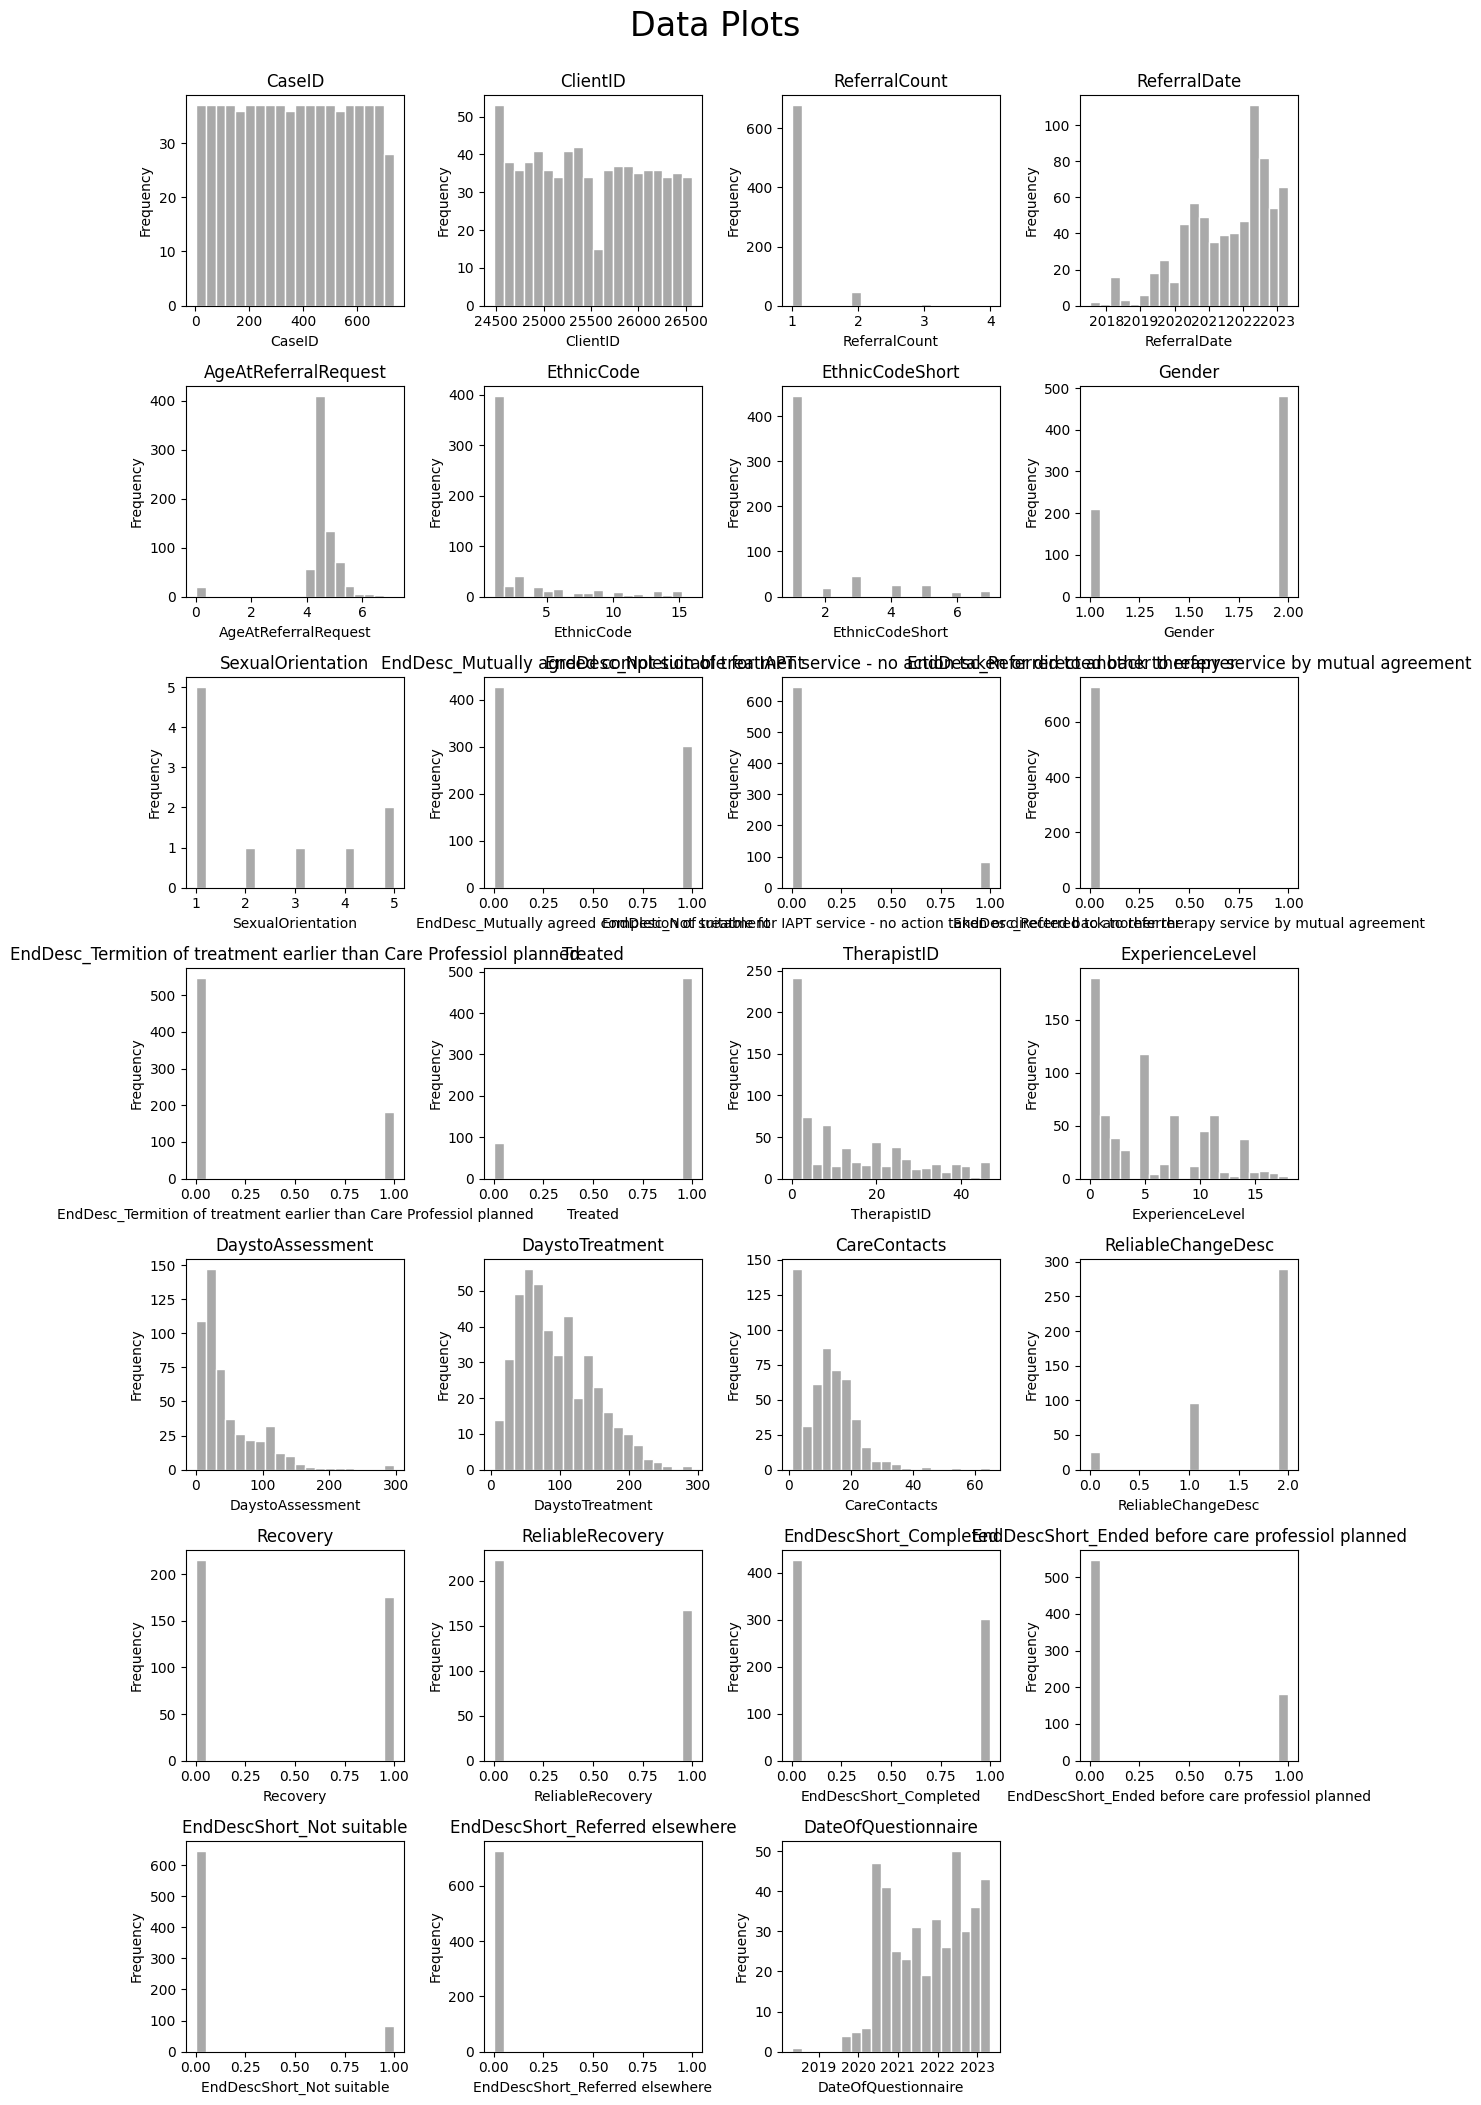

In [56]:
# plot non-questionnaire data
plot_features(nonques_df)

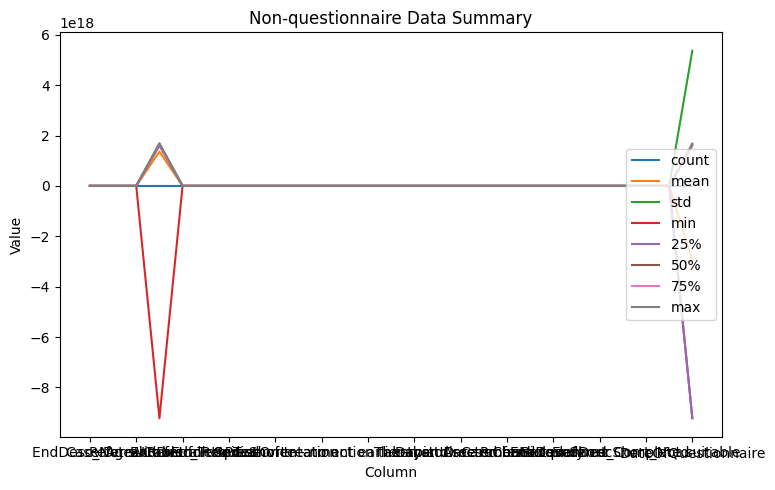

In [57]:
for col in nonques_df.columns: # convert datetime to numeric
    if nonques_df[col].dtype == 'datetime64[ns]':
        nonques_df[col] = pd.to_numeric(nonques_df[col], errors='coerce')

dfs = [nonques_df]
dfs_names = ['Non-questionnaire Data']
summary_plot(dfs, dfs_names)

## 3.2 Questionnaire Data

General plots of questionnaire data.

In [58]:
item_cols = [col for col in df.columns if 'Item' in col]
item_df = df[item_cols]

thresh_cols = [col for col in df.columns if 'Threshold' in col]
thresh_df = df[thresh_cols]

total_cols = [col for col in df.columns if 'Total' in col]
total_df = df[total_cols]

# check accounts for all questionnaire data
if (nonques_df.shape[1] + item_df.shape[1] + thresh_df.shape[1] + total_df.shape[1]) == df.shape[1]:
    print('All features are being considered')
else:
    print('All features are not being considered')

All features are being considered


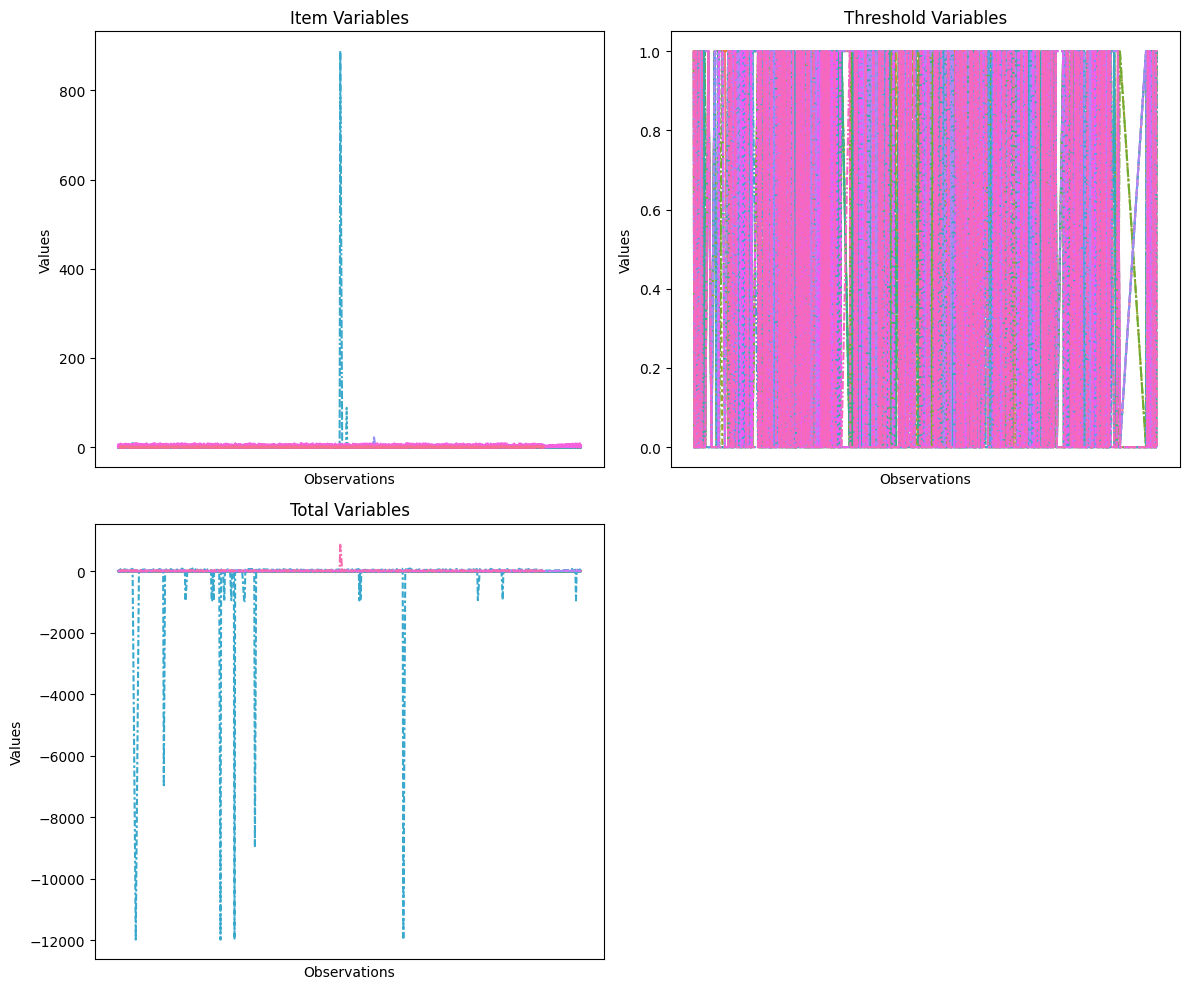

In [59]:
plt.figure(figsize=(12, 10))

plt.subplot(221)
sns.lineplot(data=item_df, legend=False)
plt.xlabel('Observations')
plt.ylabel('Values')
plt.title('Item Variables')
plt.xticks([])

plt.subplot(222)
sns.lineplot(data=thresh_df, legend=False)
plt.xlabel('Observations')
plt.ylabel('Values')
plt.title('Threshold Variables')
plt.xticks([])

plt.subplot(223)
sns.lineplot(data=total_df, legend=False)
plt.xlabel('Observations')
plt.ylabel('Values')
plt.title('Total Variables')
plt.xticks([])

plt.tight_layout()
plt.show()

** **Add random features maybe?** **

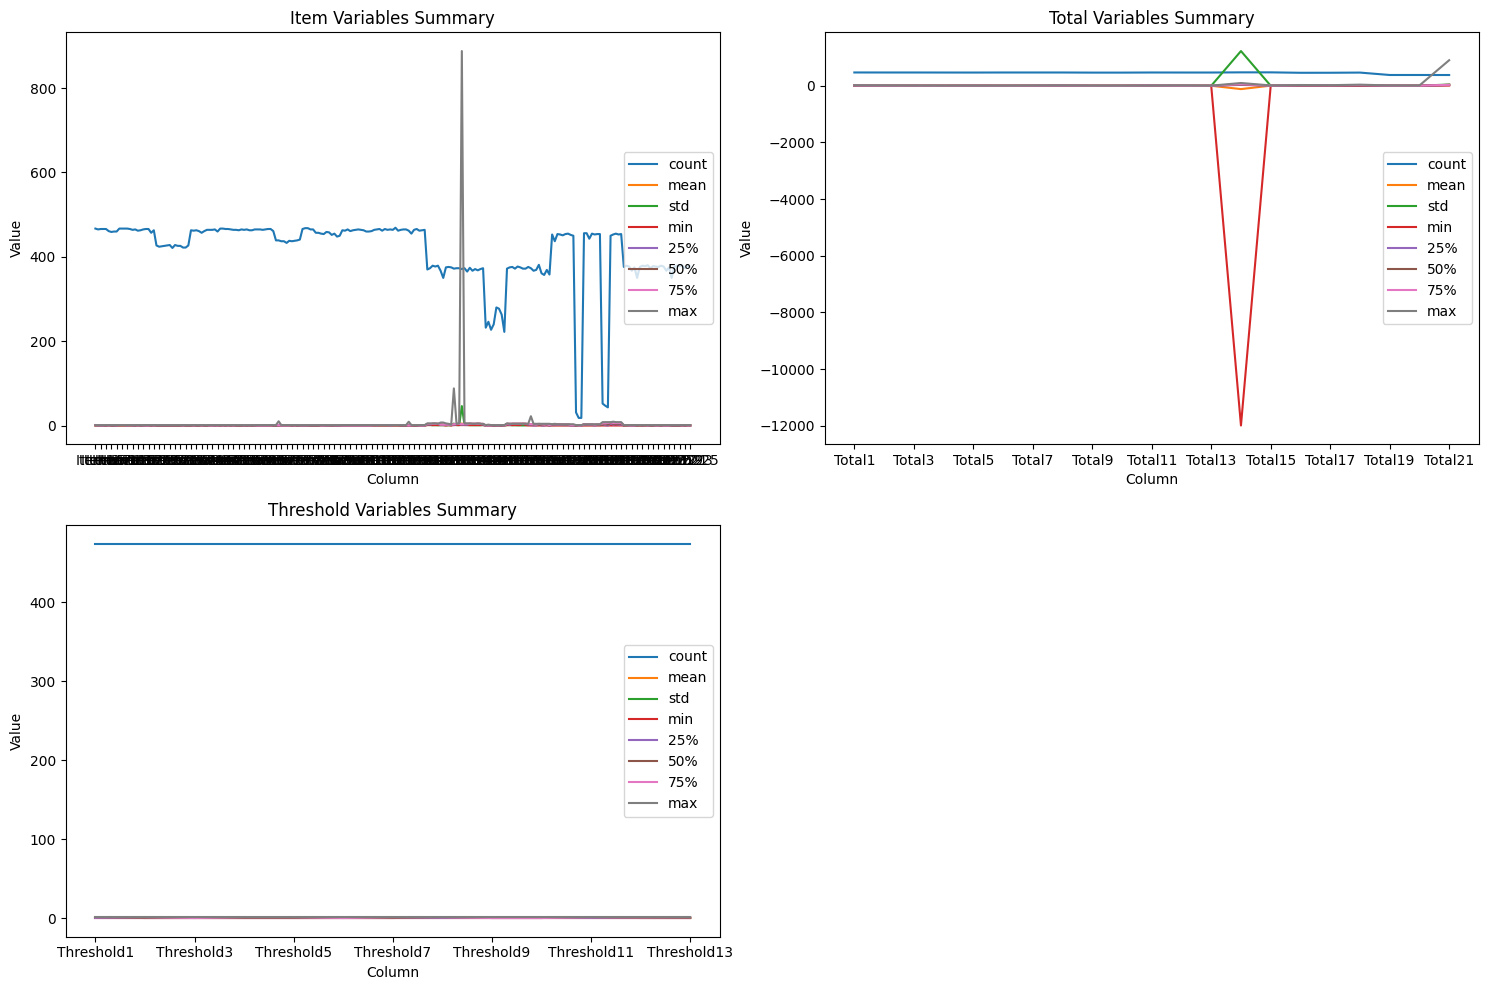

In [60]:
# questionnaire data summary
dfs = [item_df, total_df, thresh_df]
dfs_names = ['Item Variables', 'Total Variables', 'Threshold Variables']
summary_plot(dfs, dfs_names)

Items:
- Quite a lot

Totals:
- At least one negative value in Total14
- Some high values in Total21 too

Thresholds:
- Everything potentially ok in these variables

## 3.3 Stratified by Target (or End of Treatment)

In [61]:
EndDesc_cols = [col for col in df.columns if 'EndDesc' in col]
target_cols = ['Recovery', 'ReliableRecovery', 'ReliableChangeDesc'] + EndDesc_cols
targets_df = df[target_cols]

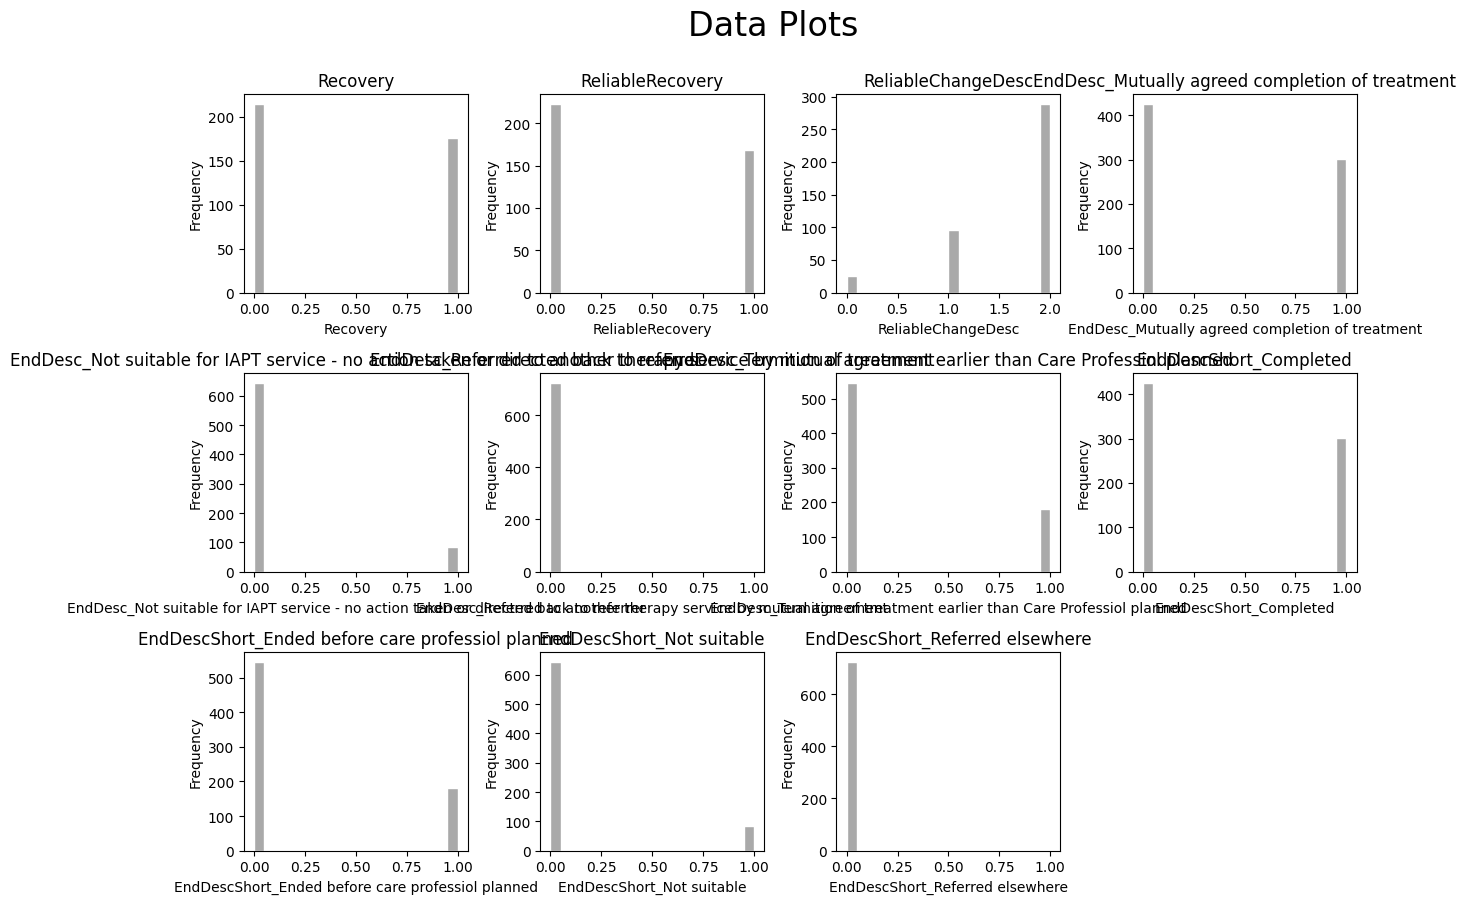

In [62]:
plot_features(targets_df)

In [64]:
cont_tb1 = pd.crosstab(df['Recovery'], df['ReliableRecovery'], dropna=False)
cont_tb2 = pd.crosstab(df['Recovery'], df['ReliableChangeDesc'], dropna=False)
cont_tb3 = pd.crosstab(df['ReliableRecovery'], df['ReliableChangeDesc'], dropna=False)

cont_tbs = [cont_tb1, cont_tb2, cont_tb3]

In [65]:
def plot_cont_tables(cont_tbs):

    def plot_cont_table(cont_tb, cmap):
        sns.heatmap(cont_tb, annot=True, fmt='d', cmap=cmap)

    plt.figure(figsize=(8, 6))

    plt.subplot(221)
    plot_cont_table(cont_tbs[0], 'Blues')
    plt.subplot(222)
    plot_cont_table(cont_tbs[1], 'Reds')
    plt.subplot(223)
    plot_cont_table(cont_tbs[2], 'Greens')

    plt.tight_layout()
    plt.show()

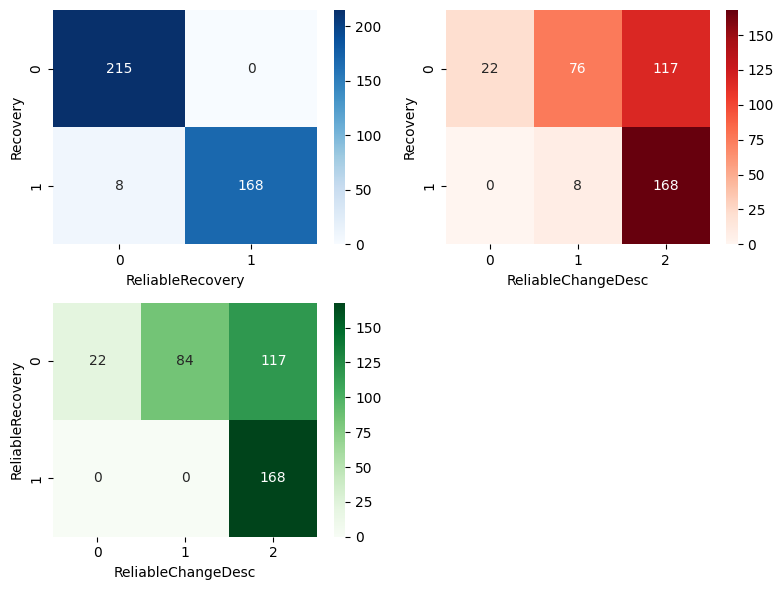

In [66]:
plot_cont_tables(cont_tbs)

In [67]:
from scipy.stats import chi2_contingency

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(cont_tb1)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

# Interpret the p-value
alpha = 0.05
if p < alpha:
    print("There is a significant association between Recovery and ReliableRecovery.")
else:
    print("There is no significant association between Recovery and ReliableRecovery.")


Chi-Square Statistic: 355.9532392800753
P-Value: 2.1417468331865305e-79
Degrees of Freedom: 1
Expected Frequencies:
[[122.62148338  92.37851662]
 [100.37851662  75.62148338]]
There is a significant association between Recovery and ReliableRecovery.


In [68]:
target = 'Recovery'

success_df = df[df[target] == 1]
notsuccess_df = df[df[target] == 0]

In [69]:
target_corr1 = df.corr(method='kendall')[target]
target_corr2 = df.corr(method='spearman')[target]

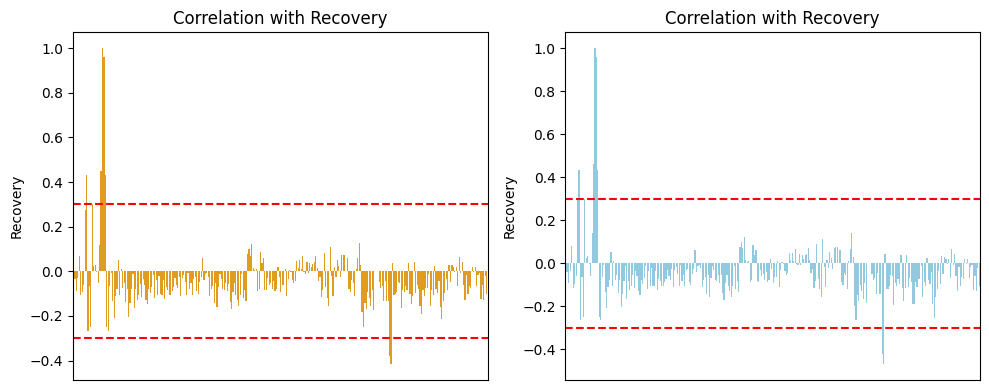

In [70]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.barplot(data=target_corr1, color='orange')
plt.axhline(y=0.3, color='r', linestyle='--')
plt.axhline(y=-0.3, color='r', linestyle='--')
plt.title(f'Correlation with {target}')
plt.xticks([])

plt.subplot(122)
sns.barplot(data=target_corr2, color='skyblue')
plt.axhline(y=0.3, color='r', linestyle='--')
plt.axhline(y=-0.3, color='r', linestyle='--')
plt.title(f'Correlation with {target}')
plt.xticks([])

plt.tight_layout()
plt.show()

In [72]:
df.columns[abs(target_corr1) >= 0.3], df.columns[abs(target_corr2) >= 0.3]

(Index(['EndDesc_Mutually agreed completion of treatment', 'Treated',
        'ReliableChangeDesc', 'Recovery', 'ReliableRecovery',
        'EndDescShort_Completed', 'Item192', 'Item193'],
       dtype='object'),
 Index(['SexualOrientation', 'EndDesc_Mutually agreed completion of treatment',
        'Treated', 'ReliableChangeDesc', 'Recovery', 'ReliableRecovery',
        'EndDescShort_Completed', 'Item192', 'Item193'],
       dtype='object'))

# 4. Feature Engineering

## 4.2 Duplicates

In [73]:
dupe_rows = df.duplicated().sum()
dupe_cols = np.transpose(df).duplicated().sum()
print(f'Duplicate rows: {dupe_rows}')
print(f'Duplicate columns: {dupe_cols}')

Duplicate rows: 0
Duplicate columns: 12


In [74]:
print('Duplicate details:\n')
find_duplicates_features(df)

Duplicate details:

EndDescShort_Completed is a duplicate of: ['EndDesc_Mutually agreed completion of treatment']
EndDescShort_Ended before care professiol planned is a duplicate of: ['EndDesc_Termition of treatment earlier than Care Professiol planned']
EndDescShort_Not suitable is a duplicate of: ['EndDesc_Not suitable for IAPT service - no action taken or directed back to referrer']
EndDescShort_Referred elsewhere is a duplicate of: ['EndDesc_Referred to another therapy service by mutual agreement']
Item215 is a duplicate of: ['Item202']
Item216 is a duplicate of: ['Item203']
Item217 is a duplicate of: ['Item204']
Item218 is a duplicate of: ['Item205']
Item220 is a duplicate of: ['Item207']
Item222 is a duplicate of: ['Item209']
Item223 is a duplicate of: ['Item210']
Item225 is a duplicate of: ['Item212']


Removing these duplicates from the dataset to reduce noise.

In [75]:
df = drop_duplicate_features(df)

## 4.3 Outliers

**Non-questionnaire Outliers**

From EDA in section 3, these features seem to contain potential outliers.

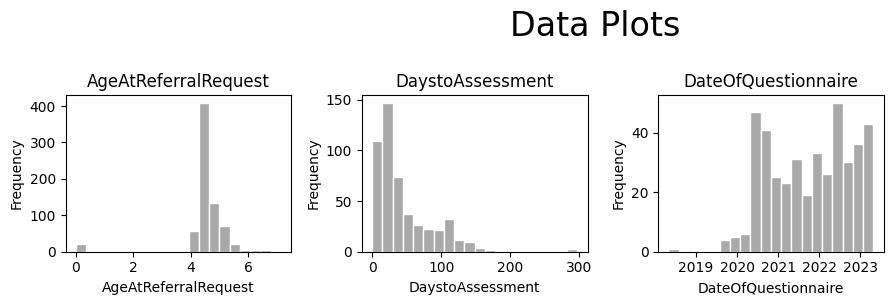

In [76]:
item1_start = df.columns.get_loc('Item1')
nonques_df = df.iloc[:, :item1_start]
observed_outliers = ['AgeAtReferralRequest', 'DaystoAssessment', 'DateOfQuestionnaire']
plot_features(nonques_df[observed_outliers])

In [77]:
nonques_df[observed_outliers].min(), nonques_df[observed_outliers].max()

(AgeAtReferralRequest                    0.0
 DaystoAssessment                          0
 DateOfQuestionnaire     2018-04-29 00:00:00
 dtype: object,
 AgeAtReferralRequest               7.141428
 DaystoAssessment                        297
 DateOfQuestionnaire     2023-05-01 00:00:00
 dtype: object)

In [78]:
age_outliers = df[df['AgeAtReferralRequest'] == 0]
print(f'Number of age outliers: {age_outliers.shape[0]}')
age_outliers.head(3)

Number of age outliers: 20


,CaseID,ClientID,ReferralCount,ReferralDate,AgeAtReferralRequest,EthnicCode,EthnicCodeShort,Gender,SexualOrientation,EndDesc_Mutually agreed completion of treatment,...,Item208,Item209,Item210,Item211,Item212,Item213,Item214,Item219,Item221,Item224
4,5,24482,1,2018-09-07,0.0,2,2,2,<NA>,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34,35,24547,1,2019-09-19,0.0,2,2,1,<NA>,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
710,711,24628,1,NaT,0.0,<NA>,<NA>,<NA>,<NA>,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [79]:
wait_outliers = df['DaystoAssessment'].sort_values(ascending=False)
wait_outliers.head(7)

56     297
557    293
33     285
581    224
596    211
342    201
599    179
Name: DaystoAssessment, dtype: Int64

In [80]:
ques_date_outliers = df['DateOfQuestionnaire'].sort_values()
ques_date_outliers.head(3)

726   2018-04-29
23    2019-08-11
37    2019-10-02
Name: DateOfQuestionnaire, dtype: datetime64[ns]

- Age of 0 seems to be outlier
- Waiting times to be assessed seem appropriate
- Questionnaire dates seems to be fair too

In [81]:
# replace outliers with nan
df.loc[df['AgeAtReferralRequest'] == 0, 'AgeAtReferralRequest'] = np.nan

** **Use quartiles to find outliers** **

**Questionnaire Outliers**

In [82]:
item_cols = [col for col in df.columns if 'Item' in col]
item_df = df[item_cols]

thresh_cols = [col for col in df.columns if 'Threshold' in col]
thresh_df = df[thresh_cols]

total_cols = [col for col in df.columns if 'Total' in col]
total_df = df[total_cols]

From the EDA, there exists negative total values. Removing these now will speed up the process.

In [83]:
# replace negative totals with nan
for col in total_df:
    df.loc[df[col] < 0, col] = np.nan # replace in df
    total_df.loc[total_df[col] < 0, col] = np.nan # replace in total_df

Viewing potential features containing outliers.

In [84]:
# detect whether cols are just 0,1,na
thresh_pot_cols = column_contents(thresh_df)
item_pot_cols = column_contents(item_df)
total_pot_cols = column_contents(total_df)

Columns only contain 0, 1 and <NA>
Columns contining more than 0, 1 and <NA>: ['Item70', 'Item119', 'Item126', 'Item127', 'Item128', 'Item129', 'Item130', 'Item131', 'Item132', 'Item133', 'Item134', 'Item135', 'Item136', 'Item137', 'Item138', 'Item139', 'Item140', 'Item141', 'Item142', 'Item143', 'Item144', 'Item145', 'Item146', 'Item147', 'Item149', 'Item156', 'Item157', 'Item158', 'Item159', 'Item160', 'Item161', 'Item162', 'Item163', 'Item164', 'Item165', 'Item166', 'Item167', 'Item168', 'Item169', 'Item170', 'Item171', 'Item172', 'Item173', 'Item174', 'Item175', 'Item176', 'Item177', 'Item178', 'Item179', 'Item180', 'Item181', 'Item185', 'Item186', 'Item187', 'Item188', 'Item189', 'Item190', 'Item191', 'Item192', 'Item193', 'Item194', 'Item195', 'Item196', 'Item197', 'Item198', 'Item199']
Columns contining more than 0, 1 and <NA>: ['Total1', 'Total2', 'Total3', 'Total4', 'Total5', 'Total6', 'Total7', 'Total8', 'Total9', 'Total10', 'Total11', 'Total12', 'Total13', 'Total14', 'Total1

Initial Beliefs
- Treshold varibles contain no outliers as there are only 0 and 1s
- Constant columns and quasi constant columns will be explored and removed later
- Potential outliers in Items and Totals

In [85]:
# potential columns containing outliers (shortening the search, only these can contain outliers)
total_pot_df = total_df[total_pot_cols]
item_pot_df = item_df[item_pot_cols]

# find outliers in Total variables
print('Outlier counts:\n')
total_outlier_df = find_outlier_cols(total_pot_df)
print('\n')
item_outlier_df = find_outlier_cols(item_pot_df)

Outlier counts:

Total3 outlier count: 83
Total4 outlier count: 13
Total6 outlier count: 140
Total9 outlier count: 134
Total10 outlier count: 45
Total11 outlier count: 39
Total12 outlier count: 1
Total13 outlier count: 170
Total21 outlier count: 12


Item70 outlier count: 1
Item119 outlier count: 75
Item128 outlier count: 30
Item129 outlier count: 51
Item130 outlier count: 25
Item131 outlier count: 75
Item132 outlier count: 162
Item133 outlier count: 23
Item134 outlier count: 129
Item135 outlier count: 21
Item136 outlier count: 1
Item137 outlier count: 118
Item138 outlier count: 48
Item139 outlier count: 1
Item140 outlier count: 149
Item141 outlier count: 150
Item142 outlier count: 41
Item143 outlier count: 73
Item144 outlier count: 49
Item145 outlier count: 43
Item146 outlier count: 41
Item149 outlier count: 40
Item156 outlier count: 105
Item157 outlier count: 121
Item158 outlier count: 30
Item159 outlier count: 55
Item160 outlier count: 7
Item161 outlier count: 8
Item163 outlier coun

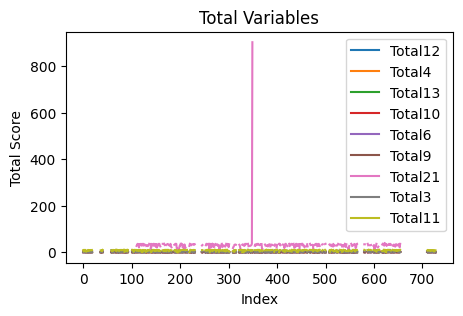

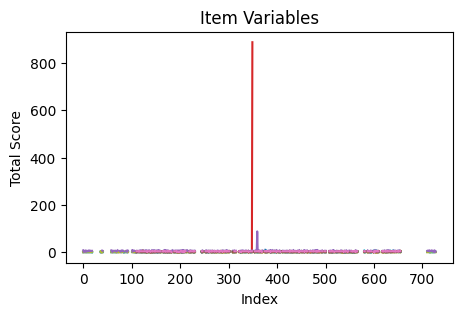

In [88]:
plot_outlier_cols(total_outlier_df, 'Total Variables')
plot_outlier_cols(item_outlier_df, 'Item Variables', legend=False)

Clearly the two massive distinct spikes are mistakes, removing these initally and takin another look before removing the other spike in the second plot seems resonable.

In [89]:
# replace outliers with nan
for col in total_outlier_df:
    df.loc[df[col] > 200, col] = np.nan
    total_outlier_df.loc[total_outlier_df[col] > 200, col] = np.nan

for col in item_outlier_df:
    df.loc[df[col] > 50, col] = np.nan
    item_outlier_df.loc[item_outlier_df[col] > 50, col] = np.nan

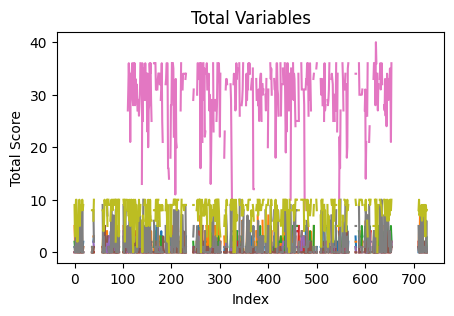

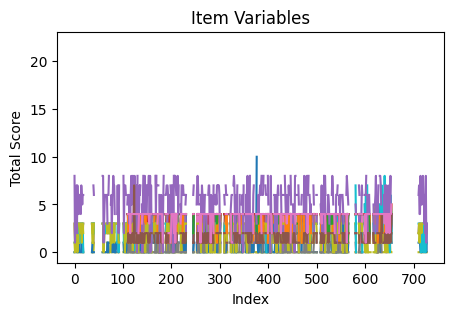

In [92]:
plot_outlier_cols(total_outlier_df, 'Total Variables', legend=False)
plot_outlier_cols(item_outlier_df, 'Item Variables', legend=False)

In [108]:
total_outlier_df[total_outlier_df > 36].dropna(axis=1, how='all').dropna(axis=0, how='all')

,Total21
622,40


Totals:
- Since there are so many instances of 36 being the highest total in Total21 it seems unlikely one achived higher, so removed.
- No large unusual points left.
- Everything else seems to be ok, since there are not many observations it would be hard to determine if one is an outlier if the difference from the rest is so small.

Items:
- This spike must be a mistake for Item70, it seems unlikely there was an option of 10 when the rest are 0 and 1.
- Similarly with the other reasoning, there are too little observations to accurately determine if any others are mistsakes since the difference in scoring is so small now.

In [136]:
def plot_outlier_cols2(outlier_df, title, color):

    plot_cols = 4
    plot_rows = len(outlier_df.columns)//4 + 1
    plt.figure(figsize = (plot_cols*3, plot_rows*3))

    for i, col in enumerate(outlier_df.columns, start = 1):
        plt.subplot(plot_rows, 4, i)
        outlier_df[col].plot(color=color)
        plt.title(col)
        plt.xlabel('Index')
        plt.ylabel('Total Score')

    plt.suptitle(title, y = 1, fontsize = 24)
    plt.tight_layout()
    plt.show()

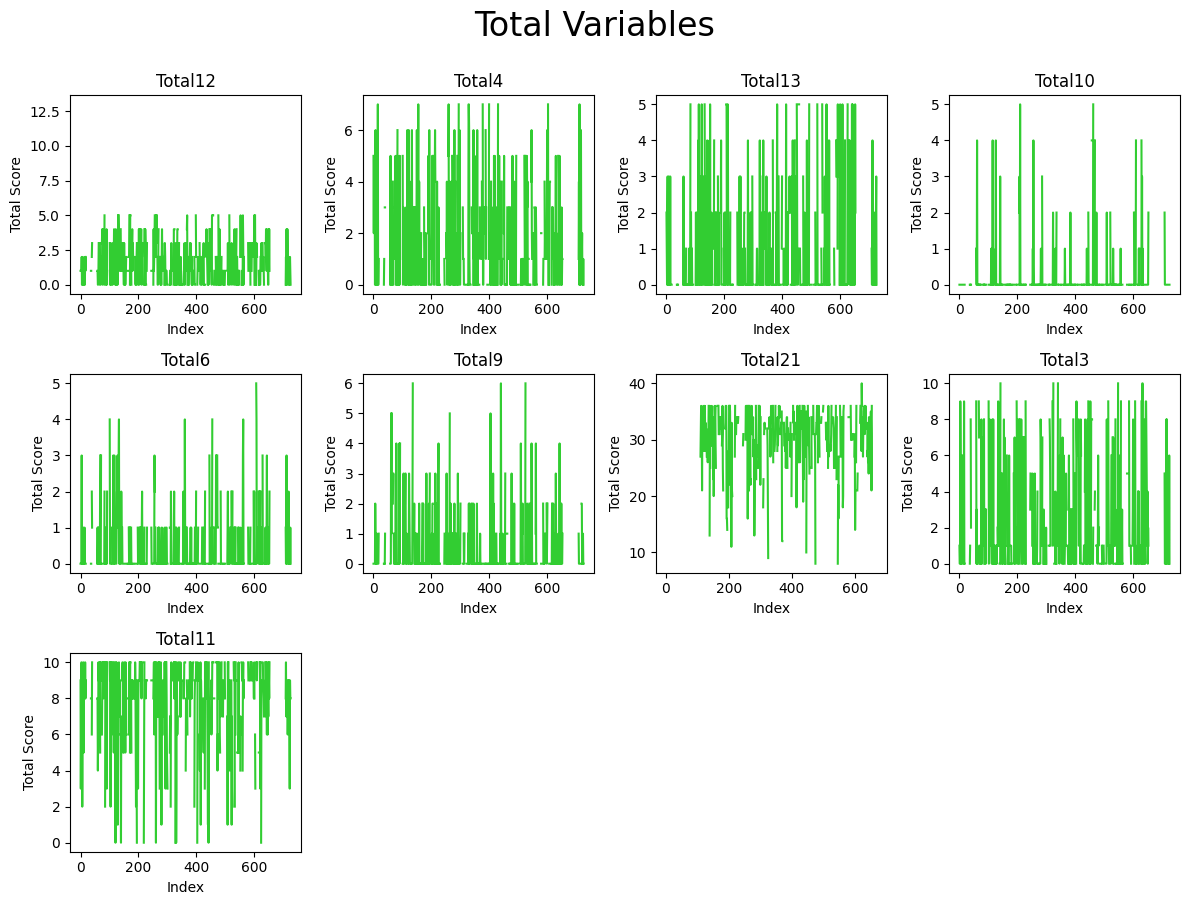

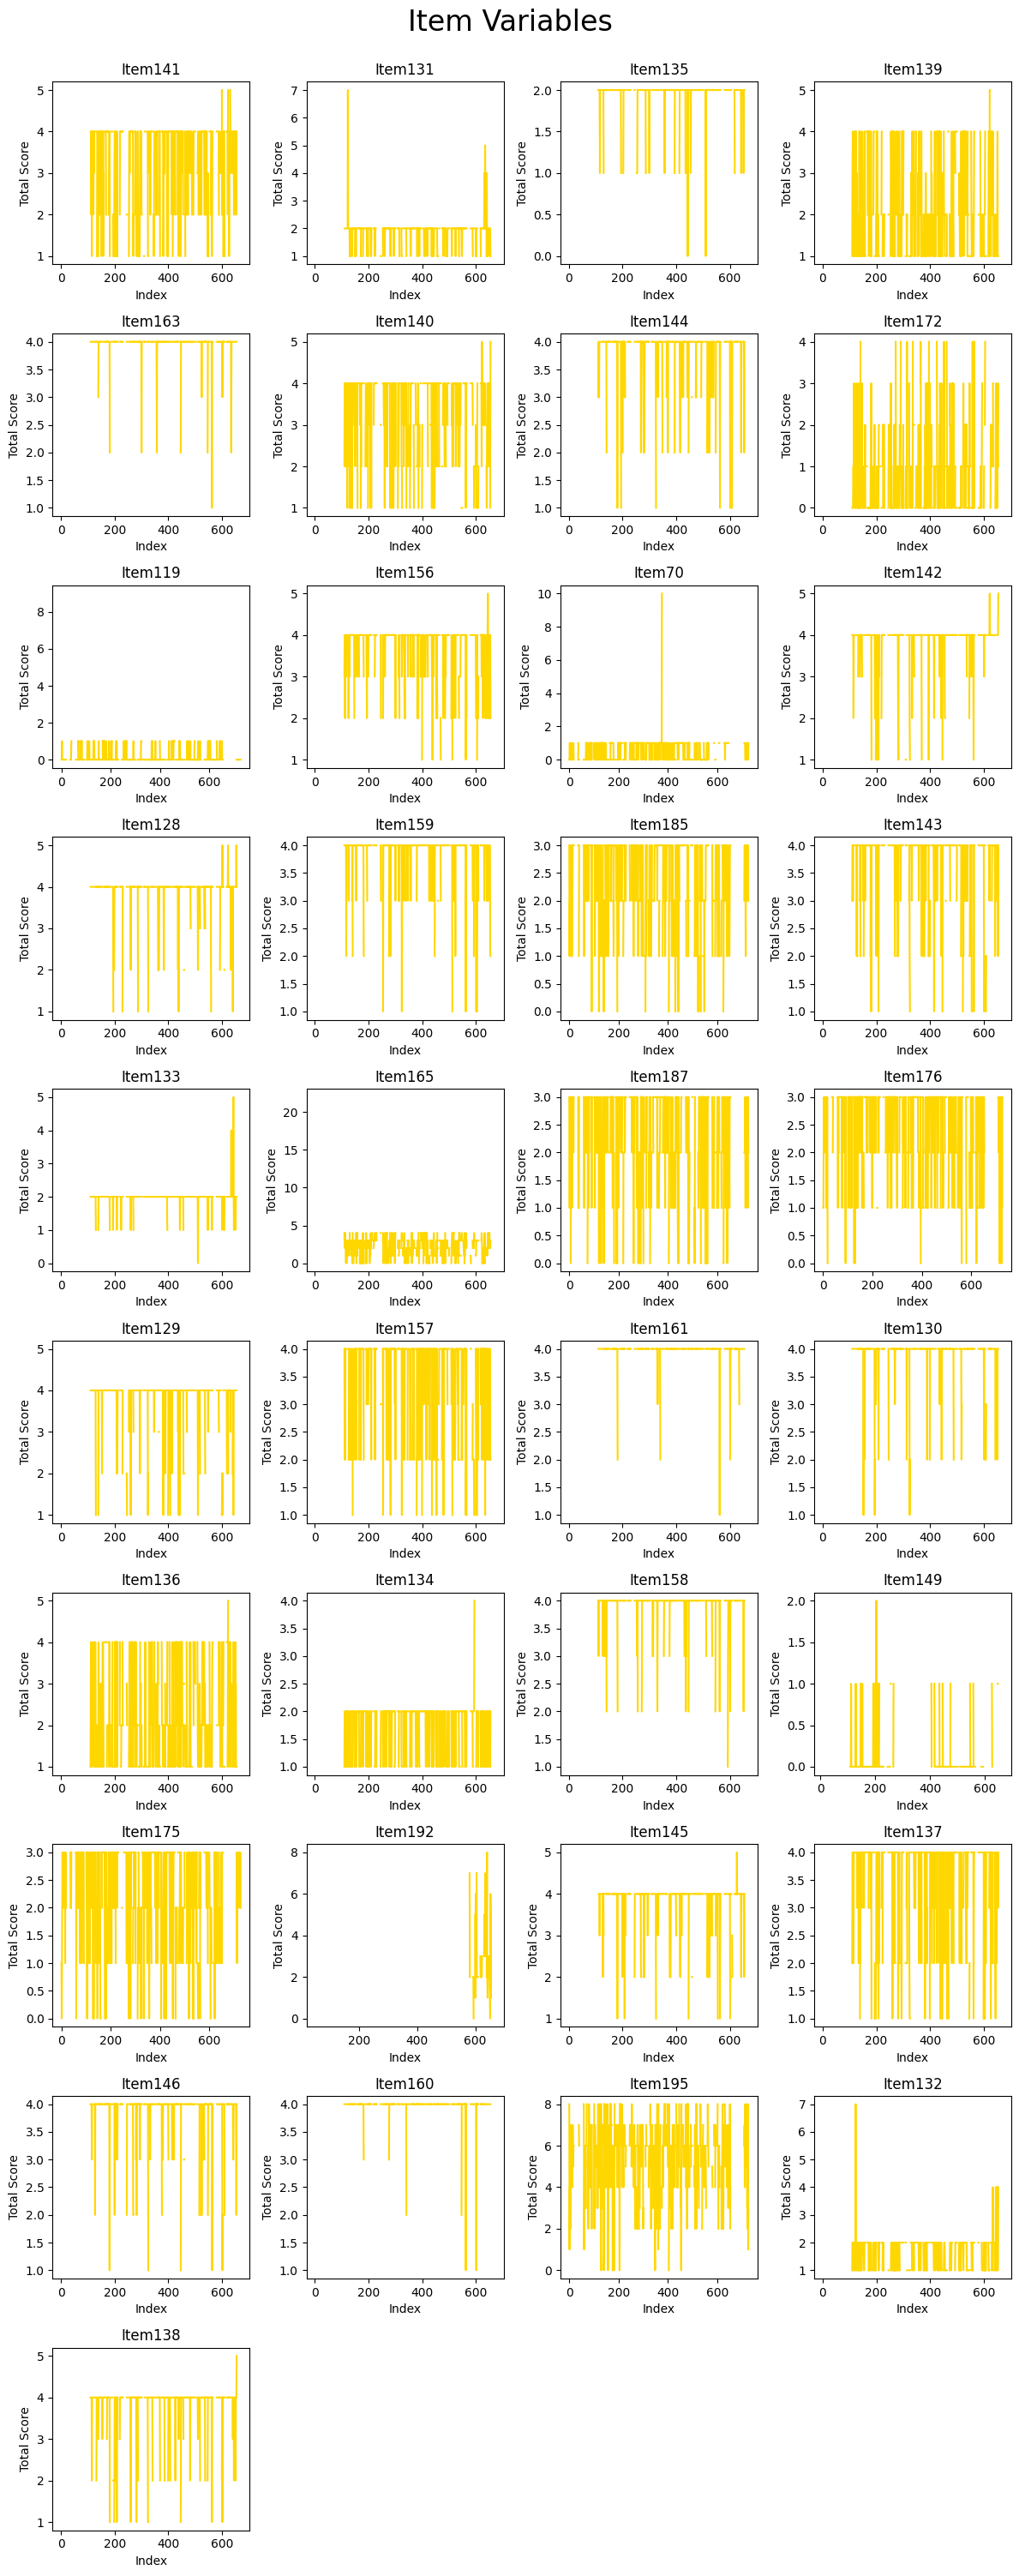

In [137]:
plot_outlier_cols2(total_outlier_df, 'Total Variables', 'limegreen')
plot_outlier_cols2(item_outlier_df, 'Item Variables', 'gold')

In [138]:
df.loc[df['Total14'] > 37, 'Total14'] = np.nan
df.loc[df['Item70'] > 3, 'Item70'] = np.nan
df.loc[df['Item132'] > 5, 'Item132'] = np.nan

** **Alter item_df and total_df if analysis goes further** **

## 4.4 Constant and Quasi Constant Features (+99.5%)

Removing useless constant columns.

In [ ]:
df = drop_const_features(df)

Exploring the data for any quasi constant features.

In [ ]:
ordinal_cols = df.select_dtypes(include = ['Int64', 'int64']).columns
ordinal_df = df[ordinal_cols]

cont_cols = df.drop(columns = ordinal_cols).columns.tolist()
cont_df = df[cont_cols]

non_datetime_cols = df.select_dtypes(exclude = ['datetime64']).columns
non_datetime_df = df[non_datetime_cols]

datetime_cols = df.select_dtypes(include = ['datetime64']).columns
datetime_df = df[datetime_cols]

Datetime data does not work well with boxplots, instead make sure there is a spread of dates as there are only two variables.

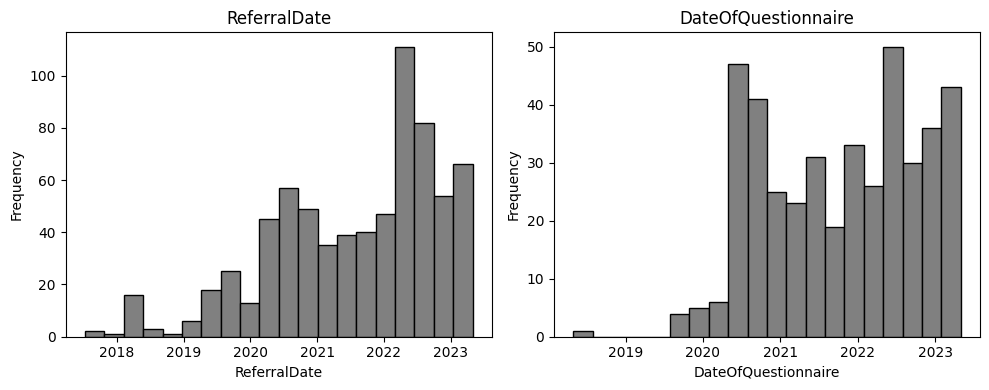

In [ ]:
plot_datetime_features(df)

Viewing the variance across the continuous variables.

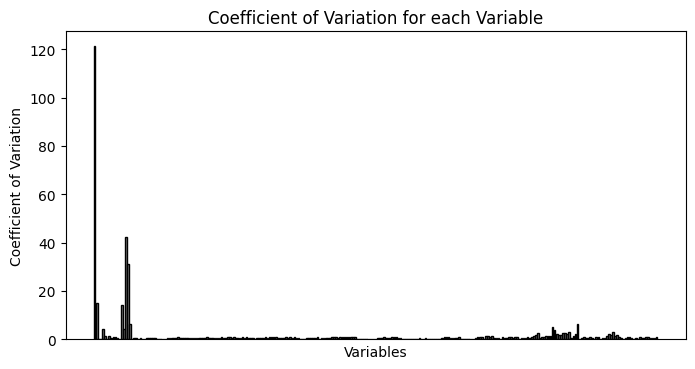

In [ ]:
# coefficient of variance
cov = df[non_datetime_cols].var() / df[non_datetime_cols].mean()

plt.figure(figsize = (8, 4))
plt.bar(cov.index, cov.values, color = 'grey', edgecolor = 'black')
plt.xlabel('Variables')
plt.ylabel('Coefficient of Variation')
plt.title('Coefficient of Variation for each Variable')
plt.xticks([])
plt.show()

In [ ]:
quasi_percentages = quasi_percentage(df)
print('Quasi percentages:\n')
print(quasi_percentages[:5])

Quasi percentages:

CaseID              0.137363
ClientID            0.549451
ReferralCount      93.131868
EthnicCode         54.532967
EthnicCodeShort    60.989011
dtype: float64


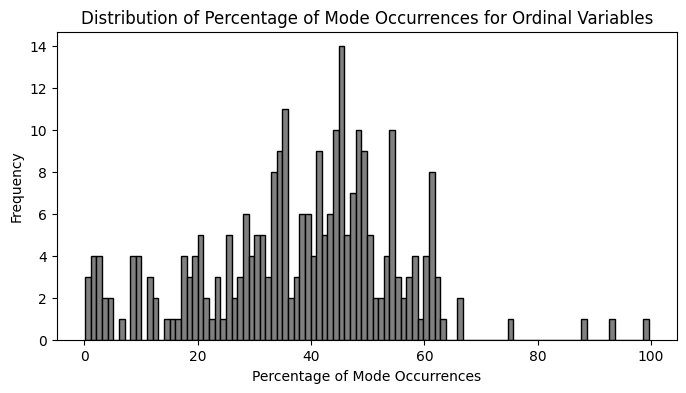

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(quasi_percentages.values, bins = 100, color = 'grey', edgecolor = 'black')
plt.xlabel('Percentage of Mode Occurrences')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of Mode Occurrences for Ordinal Variables')
plt.show()

In [ ]:
df = drop_quasi_features(df)

## 4.5 Correlation (+95%, set to load)

Inspecting highly correlated variables, whilst also removing anything that might be predicted.

** **Revisit, all variables can be used in Kendall and Spearman** **

In [ ]:
corr_matricies = generate_corr_matricies(df, load_matricies=True)
cont_corr_matrix = corr_matricies[0]
ordinal_corr_matrix_spearman = corr_matricies[1]
ordinal_corr_matrix_kendall = corr_matricies[2]

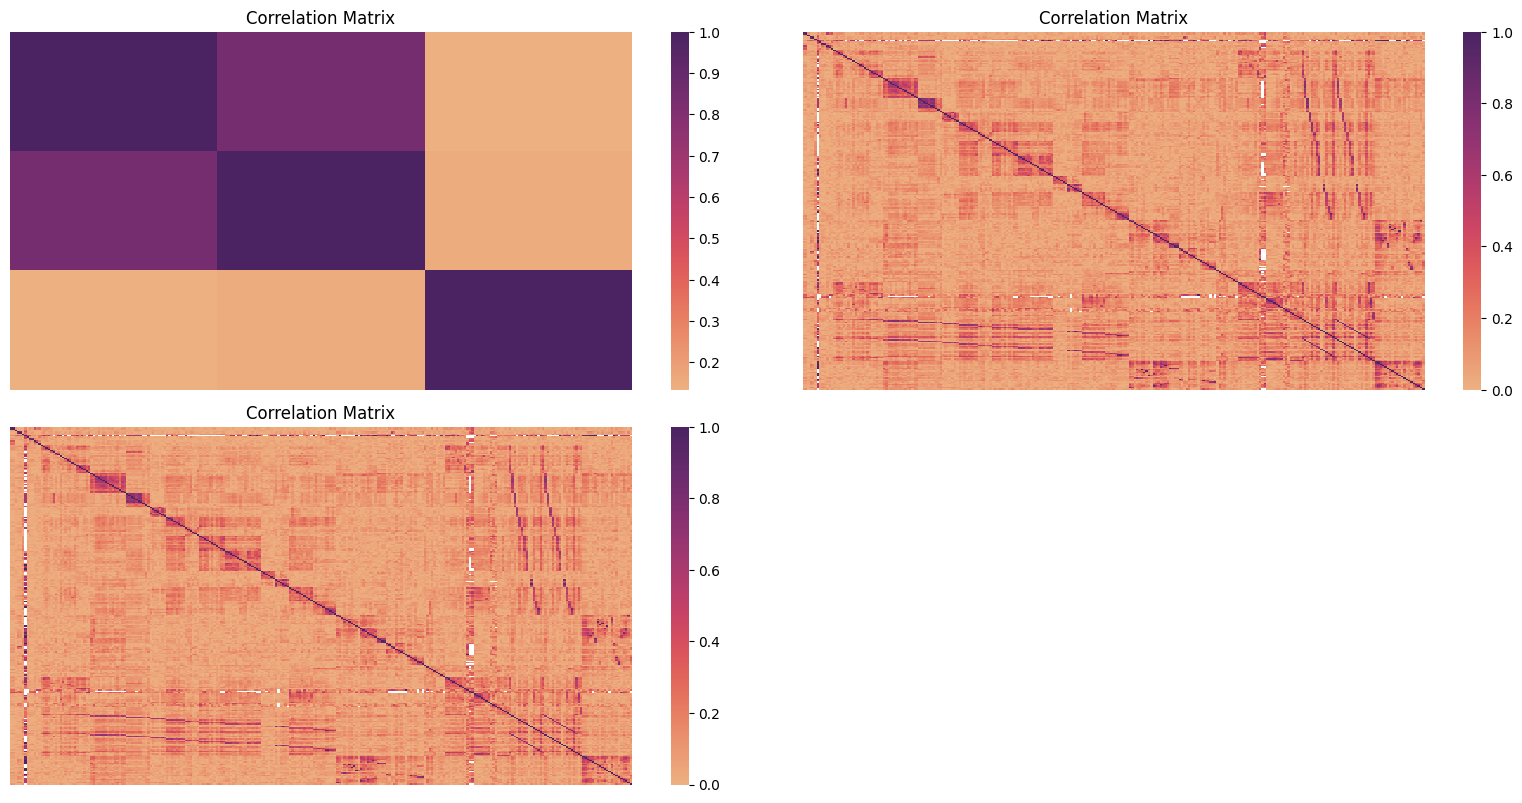

In [ ]:
corr_matricies = [cont_corr_matrix, ordinal_corr_matrix_spearman, ordinal_corr_matrix_kendall]
plot_correlation_matrices(corr_matricies)

In [ ]:
thresholds = [0.7, 0.8, 0.9, 0.95, 1.0]

correlated_features_above_treshold(corr_matricies, thresholds)

Number of variable pairs correlated above each threshold:
Continuous-Continuous Correlation (Pearson):
70.0%: 1
80.0%: 1
90.0%: 0
95.0%: 0
100.0%: 0

Ordinal-Ordinal Correlation (Spearman):
70.0%: 143
80.0%: 70
90.0%: 37
95.0%: 21
100.0%: 0

Ordinal-Ordinal Correlation (Kendall):
70.0%: 105
80.0%: 50
90.0%: 25
95.0%: 20
100.0%: 0


In [ ]:
df = remove_corr_features(df, load_matricies=True)

## 4.6 Missing Values within Features

In [ ]:
df.isna().sum()

CaseID                    0
ClientID                  0
ReferralCount             0
ReferralDate             18
AgeAtReferralRequest      0
                       ... 
Item213                 352
Item214                 349
Item219                 352
Item221                 350
Item224                 350
Length: 252, dtype: int64

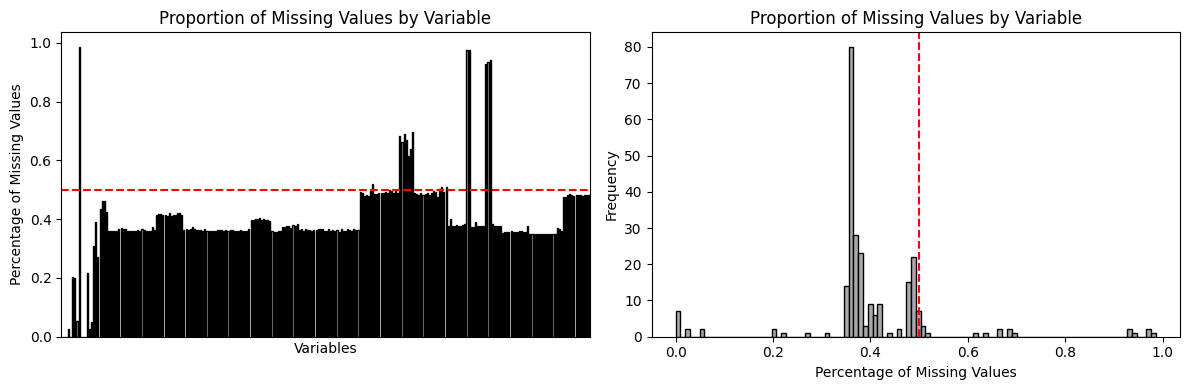

In [ ]:
missing_value_percentage = df.isna().sum() / df.shape[0]

plt.figure(figsize = (12, 4))

plt.subplot(121)
missing_value_percentage.plot(kind = 'bar', color='darkgrey', edgecolor='black')
plt.title('Proportion of Missing Values by Variable')
plt.xlabel('Variables')
plt.ylabel('Percentage of Missing Values')
plt.xticks([])
plt.axhline(y = 0.5, color='red', linestyle='--')  # line at 50%

plt.subplot(122)
plt.hist(missing_value_percentage, bins = 100, color='darkgrey', edgecolor='black')
plt.title('Proportion of Missing Values by Variable')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--')  # Line at 50%

plt.tight_layout()
plt.show()

Remove features with +50% missing data.

In [ ]:
missing_value_threshold = 0.5 # 50% missing values
df = drop_missing_values_col(df, missing_value_threshold)

## 4.7 Missing Data within Observations

In [ ]:
df.isna().sum(axis = 1)

0      48
1      45
2       0
3      45
4      58
       ..
723    58
724    62
725    59
726    58
727    58
Length: 728, dtype: int64

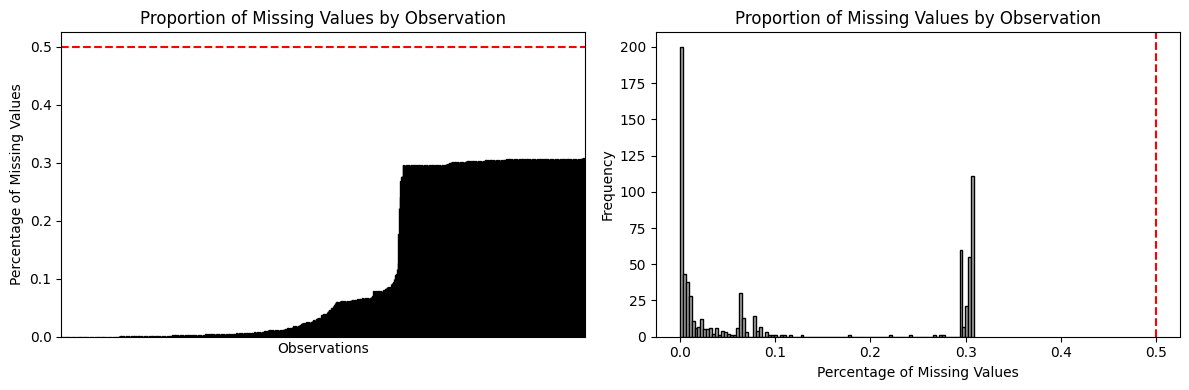

In [ ]:
missing_value_percentage = df.isna().sum(axis = 1).sort_values() / df.shape[0]

plt.figure(figsize = (12, 4))

plt.subplot(121)
missing_value_percentage.plot(kind = 'bar', color='darkgrey', edgecolor='black')
plt.title('Proportion of Missing Values by Observation')
plt.xlabel('Observations')
plt.ylabel('Percentage of Missing Values')
plt.xticks([])
plt.axhline(y = 0.5, color='red', linestyle='--')  # line at 50%

plt.subplot(122)
plt.hist(missing_value_percentage, bins = 100, color='darkgrey', edgecolor='black')
plt.title('Proportion of Missing Values by Observation')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--')  # line at 50%

plt.tight_layout()
plt.show()

The aim is to retain as much data as possible, especially since there is not a lot as it is. Luckily non seem to exceed 70%, very few above 50%. It would be best not to remove anything at this point.

## 4.8 Scaling (none)

For classification tasks its recommended to standardise data.

In [ ]:
#df = standardise(df)

## 4.9 Imputation (knn, k = 7)

In [ ]:
df = impute_data(df, method = 'knn', n_neighbours=7)

** **Make sure not rounding to non-existing number** **

## 4.10 Feature Engineering (none)

In [ ]:
#df = feature_engineering(df)

## 4.11 Feature Importance

### Dataframes

In [ ]:
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2 # neg values

In [ ]:
features = df.dropna()
target = 'Recovery'
EndDesc_cols = [col for col in df.columns if 'EndDesc' in col]
explanatory = features.drop(['Recovery', 'ReliableRecovery', 'ReliableChangeDesc'] + EndDesc_cols, axis = 1)
target = features[target]

### Univariate feature selection (used, k = 20)

In [ ]:
# fishers score
kbest_fisher = SelectKBest(score_func=f_classif, k=20)
selected_fisher = kbest_fisher.fit_transform(explanatory, target)
ind_fisher = kbest_fisher.get_support(indices=True)
names_fisher = explanatory.columns[ind_fisher]
print("Selected Features:")
print(names_fisher)

Selected Features:
Index(['Treated', 'Item2', 'Item12', 'Item16', 'Item73', 'Item83', 'Item88',
       'Item173', 'Item174', 'Item175', 'Item176', 'Item181', 'Total1',
       'Total8', 'Total14', 'Threshold1', 'Threshold7', 'Total15', 'Total16',
       'Total17'],
      dtype='object')


Text(0.5, 1.0, "Univariate Feature Selection\nFisher's Score")

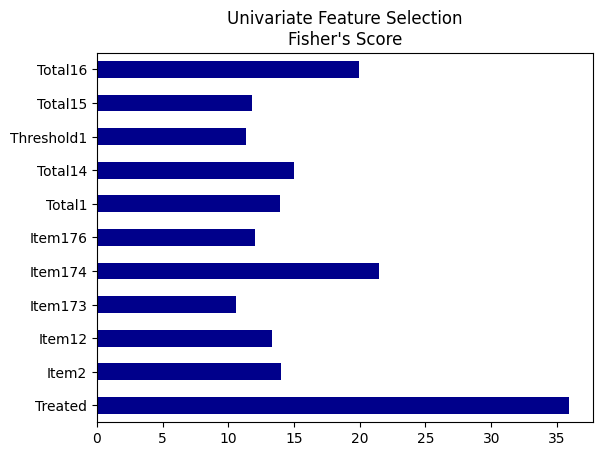

In [ ]:
# fishers score
f_values, p_values = f_classif(explanatory, target) # fisher score
feat_importances = pd.Series(f_values, index=explanatory.columns)
feat_importances = feat_importances[feat_importances > 10] # threshold
feat_importances.plot(kind='barh', color='darkblue')
plt.title("Univariate Feature Selection\nFisher's Score")

In [ ]:
# mutual information gain
def mutual_info_classif_wseed(X, y):
    return mutual_info_classif(X, y, random_state=11)
kbest_gain = SelectKBest(score_func=mutual_info_classif_wseed, k=20)
selected_gain = kbest_gain.fit_transform(explanatory, target)
ind_gain = kbest_gain.get_support(indices=True)
names_gain = explanatory.columns[ind_gain]
print("Selected Features:")
print(names_gain)

Selected Features:
Index(['ClientID', 'ReferralDate', 'Treated', 'Item1', 'Item5', 'Item19',
       'Item33', 'Item37', 'Item50', 'Item62', 'Item73', 'Item123', 'Item163',
       'Item174', 'Item181', 'Total1', 'Total9', 'Threshold1', 'Threshold2',
       'Total16'],
      dtype='object')


Text(0.5, 1.0, 'Univariate Feature Selection\nMutual Information Gain')

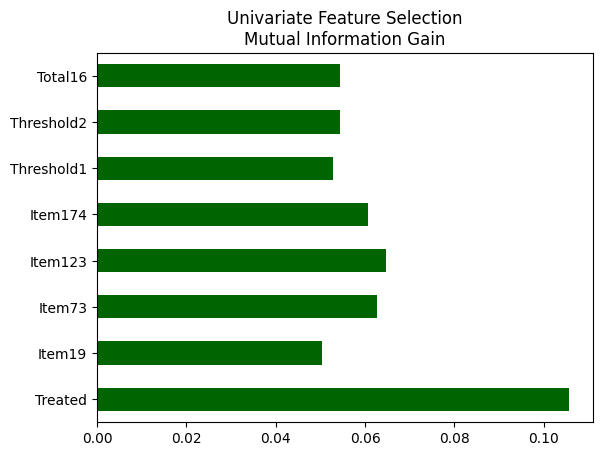

In [ ]:
# mutual information gain
importances = mutual_info_classif(explanatory, target, random_state=11) # mutual information gain
feat_importances = pd.Series(importances, index=explanatory.columns)
feat_importances = feat_importances[feat_importances > 0.05] # threshold
feat_importances.plot(kind='barh', color='darkgreen')
plt.title("Univariate Feature Selection\nMutual Information Gain")

In [ ]:
# Combine the two lists and get unique values using a set
important_combined = set(names_fisher).union(set(names_gain))

# Convert the set back to a list (optional) and print the unique feature names
important_features = list(important_combined)
print("Unique selected features:")
print(important_features)
print(f'Number of unique features: {len(important_features)}')

Unique selected features:
['Item12', 'Total14', 'Total8', 'Threshold7', 'ClientID', 'Item173', 'Item1', 'Item50', 'Item2', 'Item175', 'Item5', 'Item62', 'Total9', 'Threshold2', 'Treated', 'ReferralDate', 'Item83', 'Item123', 'Item16', 'Total1', 'Total15', 'Item33', 'Total17', 'Item163', 'Item174', 'Item73', 'Item19', 'Item176', 'Threshold1', 'Item88', 'Item37', 'Item181', 'Total16']
Number of unique features: 33


### Recursive feature elimination

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider
clf = XGBClassifier(seed=2001)
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(explanatory, target)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 2


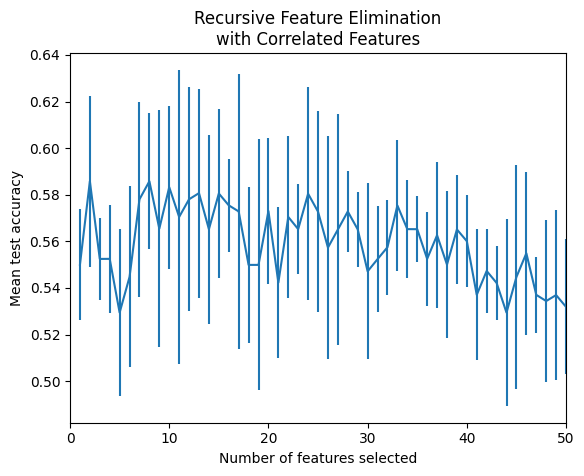

In [ ]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination\nwith Correlated Features")
plt.xlim(0, 50)
plt.show()

### Feature selection using SelectFromModel

Model-based and sequential feature selection with Ridge

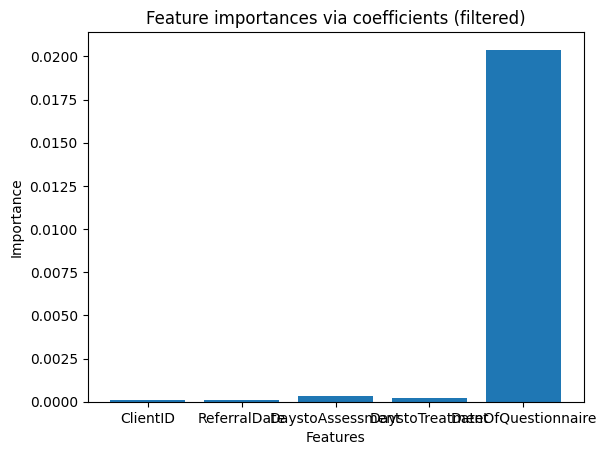

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV

# Fit RidgeCV model
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(explanatory, target)

# Calculate the importance of each feature
importance = np.abs(ridge.coef_)
feature_names = np.array(explanatory.columns)

# Filter features with importance greater than 0.0001
threshold = 0.00005
mask = importance > threshold
filtered_importance = importance[mask]
filtered_feature_names = feature_names[mask]

# Plot the filtered feature importances
plt.bar(height=filtered_importance, x=filtered_feature_names)
plt.title("Feature importances via coefficients (filtered)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

Tree-based feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(explanatory, target)
clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(explanatory)
X_new.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(391, 82)

### Sequential Feature Selection

### Correlation between target

In [ ]:
kendall_corr = df.corr(method='kendall')
spearman_corr = df.corr(method='spearman')

target = 'Recovery'
target_kendall_corr = (kendall_corr[target].abs() > 0.5).dropna()
target_spearman_corr = (spearman_corr[target].abs() > 0.5).dropna()

correlations = pd.DataFrame({'Kendall': target_kendall_corr, 'Spearman': target_spearman_corr})

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation of Features with {target}')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar', cmap='coolwarm')
plt.title(f'Correlation of Features with {target} (Absolute Values > 0.5)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.legend(title='Correlation Method')
plt.tight_layout()
plt.show()

# 5. Modelling

## 5.2 XGBoost

### Model 1

In [ ]:
param_grid1 = dict(
    #FS__threshold = ["mean", "min"],
    FS__n_features_to_select = [10, 20],
    classifier__n_estimators = [200, 500],
    classifier__max_depth = [3, 5, 10],
    classifier__learning_rate = [0.001, 0.01, 0.1],
    classifier__subsample = [0.5, 1.0],
    classifier__colsample_bytree = [0.5, 1.0])

In [ ]:
# model 1
xgb_spec_knn7_df = {
    'df': knn7_df,
    'target': 'ReliableRecovery',
    #'selector': 'SelectFromModel',
    'selector': 'RFE',
    'param_grid': param_grid1,
    'k': 5}

xgb_knn7_df = XGBoost_ModelSelection(**xgb_spec_knn7_df)

Internal CV Accuracy of estimator: 0.5991807475678443


UnboundLocalError: local variable 'num_feat' referenced before assignment

Average accuracy score: 0.6242778318727686
AUPRC score: 0.6006287037795861



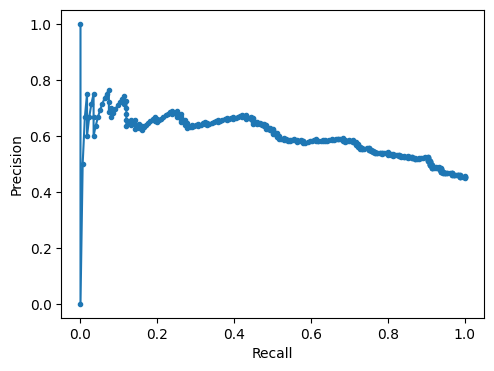

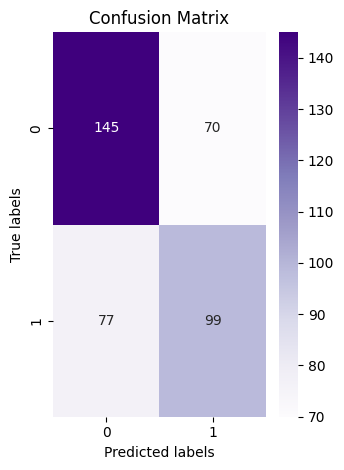

In [ ]:
ModelSelection_Summary(xgb_knn15)

In [ ]:
xgb_spec_knn10= {
    'df': knn10_df,
    'target': 'ReliableRecovery',
    'selector': 'SelectFromModel',
    'param_grid': param_grid1,
    'k': 5}

xgb_knn10 = XGBoost_ModelSelection(**xgb_spec_knn10)

Internal CV Accuracy of estimator: 0.6861239119303635
Number of selected features 115
Selected features ['CaseID', 'ReferralCount', 'ReferralDate', 'AgeAtReferralRequest', 'EthnicCode', 'EthnicCodeShort', 'Gender', 'Treated', 'TherapistID', 'ExperienceLevel', 'DaystoAssessment', 'DaystoTreatment', 'CareContacts', 'DateOfQuestionnaire', 'Item2', 'Item4', 'Item5', 'Item6', 'Item8', 'Item11', 'Item12', 'Item13', 'Item16', 'Item18', 'Item24', 'Item28', 'Item30', 'Item39', 'Item47', 'Item48', 'Item49', 'Item51', 'Item52', 'Item54', 'Item55', 'Item57', 'Item58', 'Item60', 'Item61', 'Item63', 'Item70', 'Item73', 'Item75', 'Item77', 'Item78', 'Item81', 'Item83', 'Item84', 'Item86', 'Item88', 'Item91', 'Item94', 'Item97', 'Item107', 'Item112', 'Item115', 'Item117', 'Item119', 'Item122', 'Item123', 'Item126', 'Item127', 'Item136', 'Item137', 'Item139', 'Item140', 'Item141', 'Item156', 'Item157', 'Item159', 'Item164', 'Item166', 'Item167', 'Item168', 'Item171', 'Item173', 'Item174', 'Item175', 'I

Average accuracy score: 0.6011359948068808
AUPRC score: 0.5676155769626414



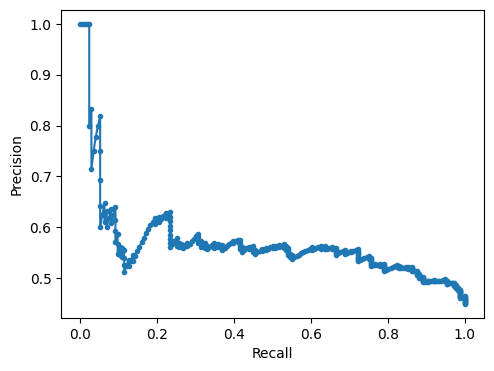

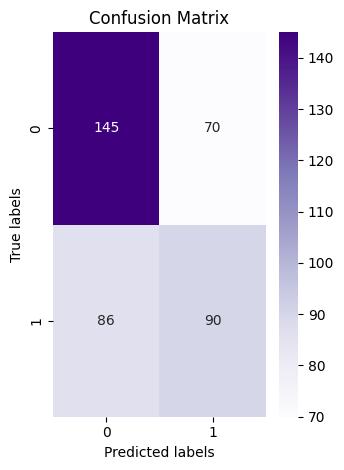

In [ ]:
ModelSelection_Summary(xgb_knn10)

In [ ]:
xgb_spec_knn7= {
    'df': knn7_df,
    'target': 'ReliableRecovery',
    'selector': 'SelectFromModel',
    'param_grid': param_grid1,
    'k': 5}

xgb_knn7 = XGBoost_ModelSelection(**xgb_spec_knn7)

Internal CV Accuracy of estimator: 0.6216589861751152
Number of selected features 115
Selected features ['CaseID', 'ClientID', 'ReferralDate', 'AgeAtReferralRequest', 'EthnicCode', 'EthnicCodeShort', 'Gender', 'Treated', 'TherapistID', 'ExperienceLevel', 'DaystoAssessment', 'DaystoTreatment', 'CareContacts', 'DateOfQuestionnaire', 'Item2', 'Item4', 'Item5', 'Item6', 'Item8', 'Item9', 'Item16', 'Item17', 'Item21', 'Item22', 'Item23', 'Item26', 'Item29', 'Item32', 'Item33', 'Item35', 'Item37', 'Item40', 'Item41', 'Item43', 'Item46', 'Item47', 'Item48', 'Item50', 'Item52', 'Item54', 'Item58', 'Item59', 'Item61', 'Item73', 'Item75', 'Item77', 'Item78', 'Item81', 'Item82', 'Item83', 'Item84', 'Item87', 'Item88', 'Item91', 'Item94', 'Item97', 'Item102', 'Item103', 'Item109', 'Item114', 'Item117', 'Item121', 'Item123', 'Item126', 'Item127', 'Item136', 'Item139', 'Item156', 'Item164', 'Item165', 'Item166', 'Item167', 'Item168', 'Item171', 'Item174', 'Item175', 'Item176', 'Item177', 'Item178', 

Average accuracy score: 0.613988964621876
AUPRC score: 0.5795533839238206



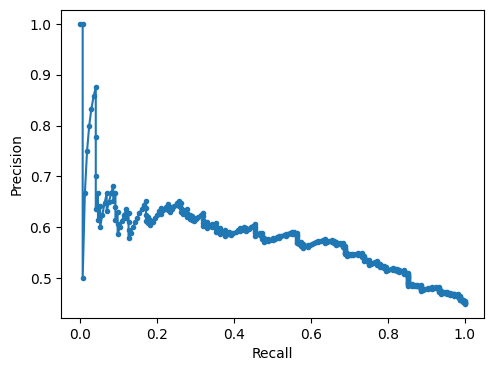

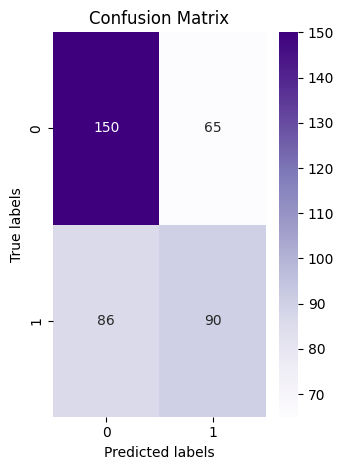

In [ ]:
ModelSelection_Summary(xgb_knn7)

### Model 2

In [ ]:
# hyperparameters for XGBoost and feature selector
param_grid2 = dict(
    FS__threshold = ["mean", "median"],
    classifier__n_estimators = [400, 500, 600],
    classifier__max_depth = [5, 7, 10],
    classifier__learning_rate = [0.05, 0.1, 0.5],
    classifier__min_child_weight = [0, 1],
    classifier__subsample = [0.8, 1],
    classifier__colsample_bytree = [0.8, 1],
    classifier__gamma = [0, 0.01],
    classifier__lambda = [0, 0.01],
    classifier__alpha = [0, 0.01])

### Final Model

In [ ]:
# Initialize XGBoost classifier with best hyperparameters
best_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.1,
    'min_child_weight': None,
    'subsample': 1.0,
    'colsample_bytree': 0.5,
    'gamma': None,
    'reg_lambda': None,
    'reg_alpha': None
}

xgb_classifier = XGBClassifier(**best_params)

# Feature selector
feature_selector = SelectFromModel(xgb_classifier)

# Create a pipeline
pipeline = Pipeline([
    ('FS', feature_selector),
    ('classifier', xgb_classifier)])

# Train the model on the entire dataset
pipeline.fit(X, y)

# 6. Shortend Version

## Data

In [ ]:
# preprocessing
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# eda
import seaborn as sns
from scipy import stats

# processing
from sklearn.preprocessing import MinMaxScaler # normalisation
from sklearn.preprocessing import Normalizer # works on rows not features
from sklearn.preprocessing import StandardScaler # standardisation

from statsmodels.imputation.mice import MICEData
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# modelling
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [ ]:
print('Percentage missing data:')
print(83090 / 208208 * 100)

Percentage missing data:
39.90720817643895


In [ ]:
df, raw_df = load_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create different processed datasets
data = raw_df.copy()
data = Clean_Data(data)

#knn3_df = Prepare_Data(data, imputation_method='knn', n_neighbours=3, iter=10)
#knn5_df = Prepare_Data(data, imputation_method='knn', n_neighbours=5, iter=10)
knn7_df = Prepare_Data(data, imputation_method='knn', n_neighbours=7, k_features=20)

## Model

In [ ]:
param_grid1 = dict(
    #FS__threshold = ["mean", "min"],
    FS__n_features_to_select = [10, 15],
    classifier__n_estimators = [200, 500],
    classifier__max_depth = [3, 5],
    classifier__learning_rate = [0.01, 0.1],
    classifier__subsample = [0.5, 1.0],
    classifier__colsample_bytree = [0.5, 1.0])

# model 1
xgb_spec_knn7_df = {
    'df': knn7_df,
    'target': 'ReliableRecovery',
    #'selector': 'SelectFromModel',
    'selector': 'RFE',
    'param_grid': param_grid1,
    'k': 10}

xgb_knn7_df = XGBoost_ModelSelection(**xgb_spec_knn7_df)

Internal CV Accuracy of estimator: 0.5897619047619047
Number of selected features 15
Selected features ['Item12', 'Total14', 'Total8', 'Item173', 'Item5', 'Total9', 'Treated', 'Item83', 'Item16', 'Total15', 'Total17', 'Item73', 'Item176', 'Item88', 'Total16']
Max depth 5
Number of trees 200
Learning rate 0.1
Minimum child weight None
Subsample 0.5
Colsample bytree 0.5
Gamma None
Lambda None
Alpha None
Accuracy performance on this test set: 0.6
--------------------------------------------------
Internal CV Accuracy of estimator: 0.5745238095238094
Number of selected features 10
Selected features ['Item173', 'Item1', 'Item2', 'Item5', 'Item62', 'Treated', 'Item83', 'Item16', 'Item73', 'Item176']
Max depth 3
Number of trees 500
Learning rate 0.1
Minimum child weight None
Subsample 0.5
Colsample bytree 0.5
Gamma None
Lambda None
Alpha None
Accuracy performance on this test set: 0.6153846153846154
--------------------------------------------------
Internal CV Accuracy of estimator: 0.610873

In [ ]:
Feature Selection Frequency:
Item173: 5
Total14: 4
Treated: 5
Item83: 4
Item16: 5
Total17: 3
Item88: 3
Total16: 4
Item5: 4
Item73: 2
Item176: 3
Total8: 2
Item1: 2
Item2: 2
Total1: 2
Item12: 1
Total9: 2
Total15: 1
Threshold7: 1
Item175: 1
Item123: 1
Item33: 1
Item37: 1
Item62: 1

Features selected more than once:
Item173: 5
Treated: 5
Item16: 5
Item83: 4
Total14: 4
Total16: 4
Item5: 4
Item176: 3